# 基于GAN和LSTM的压强场时空序列预测

## 0 导入包

In [ ]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Activation, Dense, Flatten, Input, Reshape, BatchNormalization, Conv2DTranspose, UpSampling2D, LeakyReLU
from tensorflow.keras.layers import LSTM, RNN, SimpleRNNCell, LSTMCell
from tensorflow.keras.models import Sequential, Model
from keras import backend as K
from PIL import Image
import scipy.io as io
from tqdm import tqdm
import random

## 摘要

<font color=royalblue>**物理场是对物理信息或物理量在时空坐标上抽象**</font>，其规模大至洋流运动、大气流动、地球的重力结构、小至容器中的流体压强、平板上扩散传热. <font color=royalblue>**几乎任何在时空坐标上变化的物理量都可以抽象为场的变化**</font>，例如温度场、压强场、涡度场等. 求解物理场运动变化的微分方程，<font color=royalblue>**对场变化的规律建模并进行预测具有极其重要的理论研究意义和实际应用价值**</font>. 理论研究层面，场是对物理量变化规律的基本描述. 实际应用层面，物理场的建模预测可用于洋流活动评估、侦测海啸等自然灾害；天气预报依赖于对大气流动的预测和分析；北京2022年冬奥会要实现对小范围场地内温度场的精准控制. 然而，<font color=royalblue>**大部分物理场的建模和求解都十分困难**</font>. 例如流体流动的Navier-Stokes方程，人们至今没有找到方程的解析解，只能依靠微分方程数值解或其它数值模拟方法进行求解. 本文利用深度神经网络给出物理场建模预测的另一种数值求解思路. 我们<font color=royalblue>**将二维物理场在各个时刻的分布转换为图片信息输入到对抗生成网络(GAN)，让GAN对物理场的结构进行建模**</font>，随后，<font color=royalblue>**将GAN的生成器G与判别器D分离，让生成器G与一个长短期记忆神经网络(LSTM)拼接**</font>，LSTM以场的图片序列作为输入，并通过一个解码器得到生成器G所需的输入向量，最终的预测结果由生成器G输出. 我们<font color=royalblue>**以二维圆柱绕流压强场的建模预测为例，详细讨论了模型的建立、训练、测试和调优. 与不带GAN的自编码LSTM(AutoencoderLSTM)相比，结合GAN的LSTM在性能上有较大提升.**</font>

## 目录

* **1 问题说明和数据集准备**
  * 1.1 问题说明
  * 1.2 数据集准备
    * 1.2.1 数据集说明
    * 1.2.2 导入压强场数据
    * 1.2.3 创建序列数据生成器
* **2 GAN对压强场建模**
  * 2.1 GAN模型的搭建
    * 2.1.1 GAN基类的构造
    * 2.1.2 基于DCGAN和WGAN的混合GAN
  * 2.2 模型训练
    * 2.2.1 基于Gradient Clipping的MixedGAN
    * 2.2.2 基于Gradient Penalty的MixedGAN
    * 2.2.3 基于Wasserstein Loss的MixedGAN
  * 2.3 生成效果对比和MixedGAN模型选择
* **3 GAN-LSTM模型**
  * 3.1 时空序列预测模型的搭建
    * 3.1.1 AutoencoderLSTM
    * 3.1.2 GAN-LSTM
    * 3.1.3 组合时空序列模型
  * 3.2 模型的训练
    * 3.2.1 基于AutoencoderLSTM
    * 3.2.2 基于GAN-LSTM
  * 3.3 模型预测效果评估
* **4 模型调优**
  * 4.1 学习率调优
  * 4.2 优化器的选择
  * 4.3 编码器的设计
  * 4.4 LSTM隐藏层的数量
  * 4.5 提供历史信息的长度
  * 4.6 训练序列的生成方式 
  * 4.7 调优效果检验
* **5 结论和总结**
  * 5.1 实验结论
  * 5.2 应用前景
  * 5.3 未来研究方向
* **6 参考文献**

## 1 问题说明和数据集准备

### 1.1 问题说明

我们使用深度神经网络对二维圆柱绕流进行建模预测，观察流体压强的运动变化情况. 考虑一个无量纲自由流动，流速$v_0=1$，方向向右。圆柱直径$D=1$，圆柱中心位于坐标原点，流体运动粘度$\kappa=0.01$. 该流动模型的雷诺数$Re$为：
$$ Re = \frac{v_0\cdot D}{\kappa} =100.$$

考虑流体在圆柱右侧区域$(x,y)\in[1,8]\times [-2,2]$内的流动情况，运动时间范围为$t\in[0,20]$. 流体满足的Navier-Stokes方程为：
$$
\left\{
\begin{array}{l}
u_t + (uu_x+vu_y) = -p_x + \kappa\cdot (u_{xx}+u_{yy}) \\
v_t + (uv_x+vv_y) = -p_y + \kappa\cdot (v_{xx}+v_{yy}) \\
u_x + v_y = 0 \\
\end{array}
\right.
$$
其中，$u(x,y,t),v(x,y,t)$分别表示$t$时刻水平和垂直方向的速度分量，$p(x,y,t)$代表$t$时刻的压强场，是我们此次试验关心的物理量.

二维圆柱绕流的示意图如下所示，流体从左向右流动，我们考察圆柱右侧矩形区域的压强的变化情况.

<div align=center>
<img src="figure/二维圆柱绕流示意图.png" width=600 alt="二维圆柱绕流示意图">
</div>

### 1.2 数据集准备

#### 1.2.1 数据集说明

实验数据来自于<font color=blue>**[1]**</font>提供的高保真数据，<font color=green>**数据采样了二维圆柱绕流过程中右侧区域内20秒内的压强、速度场分布，采样间隔为0.1秒. 我们只需要用到其中的压强场数据**</font>

#### 1.2.2 导入压强场数据

原始的数据保存在.mat文件中，<font color=royalblue>原始数据维度为(200,5000)，其中200表示时间采样次数(在20秒内每0.1秒进行一次采样)，5000是压强场被拉直后的维度，真实的压强场大小为(50,100).</font>

我们将压强场数据的维度重新恢复至(50,100)，<font color=tomato>为了便于后续卷积神经网络的计算，我们将数据上采样至(64,128)，并将代表压强大小的浮点数据规范化至[0,255]的标准像素范围内.</font>

In [ ]:
def process_data():
    """
    process_data()
        加载压强场数据集，数据集维度(timesteps,height,width) = (200,50,100)\n
        为了便于后续CNN处理，将场的大小变换到(50,100) -> (64,128)\n
        所读入的数据是真实的压强采样，取值为压强大小\n
        将数据标准化到[0,1]内，再转为[0,255]像素范围内的uint8数据，将其从场数据变为图片上数据
    """
    # 读入mat原始的mat数据
    data = io.loadmat('Data/cylinder_nektar_wake.mat')
    # 选择压强场数据
    Pressure = data['p_star']
    # 将压强序列转换为压强长大小(50,100,1)，1表示单通道
    X_data = Pressure.T.copy()
    X_data = np.reshape(X_data,(X_data.shape[0],50,100,1))
    # 为了便于卷积处理，转换为(64,128)
    X_data = tf.image.resize(X_data,size=(64,128))
    X_data = X_data.numpy()
    # 先标准化到[0,1]
    X_data = (X_data - X_data.min()) / (X_data.max() - X_data.min())
    # 再标准化至[0,255]的像素
    X_data = (255*X_data).astype(np.uint8)
    return X_data

<font color=royalblue>**查看压强场$t_0$时刻的分布图片**</font>

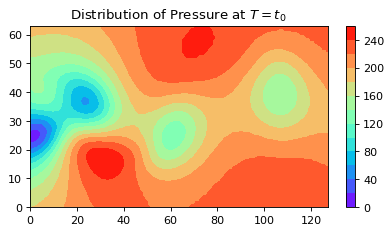

In [ ]:
data = process_data()
fig = plt.figure(figsize=(6,3),dpi=80)
xticks = np.arange(128)
yticks = np.arange(64)
plt.contourf(xticks,yticks,data[0][:,:,0],cmap=plt.cm.rainbow,levels=15)
plt.title("Distribution of Pressure at $T=t_0$")
plt.colorbar()

#### 1.2.3 创建序列数据生成器

在训练循环神经网络时，我们需要从压强场数据中生成时间连续的序列数据，因此需要创建一个数据生成器，针对训练集、验证集和测试集，我们有不同的生成策略

**(1) 对于训练集**  
我们首先将压强场的图片序列拉直，维度从(64,128)转换为(64 $\times$ 128,)，<font color=tomato>**每一次生成器将生成两个维度为(num_steps,batch_size,seq_size)的数据`X_train`和`y_train`**</font>，其中：
* num_steps表示循环神经网络训练时使用的时间步长，即滞后阶
* batch_size表示数据的批量大小
* deq_size表示每个样例的序列长度，这里等于54*128=8192

`X_train`和`y_train`在第一个维度上的数据是随时间连续的，且`y_train`的每一个取值对应于`X_train`的下一个时刻的取值，它们分别作为模型的输入和标签.

此外，<font color=tomato>**生成器生成数据可以指定两种模式，随机打乱和顺序生成：**</font>
* 当指定为<font color=tomato>**随机打乱**</font>，则生成的每个批量的数据<font color=royalblue>**在时间维度上是不连续**</font>
* 当指定为<font color=tomato>**顺序生成**</font>，则生成的每个批量的数据<font color=royalblue>**在时间维度上是相邻的**</font>

**(2) 对于验证集和测试集**  
每次验证集和测试集生成的数据批量大小都是1，<font color=tomato>**生成器会生成两个数据`X_valid`，`y_valid`（或`X_test`，`y_test`），维度分别为(preinfo_steps,1,seq_size)和(pred_steps,1,seq_size)**</font>  
* preinfo_steps表示提供给模型“预热”的滞后时间段步长，即$t-p,t-p+1,\cdots,t-1$时刻的信息
* pred_steps表示模型需要预测的未来信息的时间步长，即$t,t+1,\cdots,t+q$时刻的信息

因此，<font color=tomato>**`y_valid`是紧接着`X_valid`的压强场分布信息**</font>，<font color=royalblue>**模型需要依靠提供的滞后信息`X_valid`预测未来pred_steps阶的信息`y_pred`，然后用`y_valid`检验`y_pred`的正确率**</font>

In [ ]:
class SeqDataLoader:
    """
    class SeqDataLoader(batch_size, num_steps, use_random_iter, train_size : float=0.8, valid_size :  float=0.1, datasets : str='train')
    |   序列数据生成器，构造用于LSTM模型训练的序列迭代器
    |   
    |   Parameters
    |   ----------
    |   batch_size : int
    |       迭代器的批量大小
    |   num_steps : int
    |       序列数据的前置时间步长，即(y_{t-p},y_{t-p+1},y_{t-1})，其中p = num_steps
    |   use_random_iter : bool
    |       在生成批量时间序列数据时，是否打乱批量时间的相邻关系\n
    |       如果为True，则每个批量不连续，从数据集中随机挑选\n
    |       如果为False，则每个批量是从时间序列中连续采样的\n
    |   train_size : float, optional
    |       设置训练数据集的比例，默认值0.8
    |   valid_size : float, option
    |       设置验证数据集的比例，默认值0.1
    |   datasets : str, optional
    |       所需要的数据集类型，取值['train','valid','test']，默认值'train'
    |   preinfo_steps : int, optional
    |       在验证集和测试集中，提供的前置序列信息长度，默认值5
    |   pred_steps : int, optional
    |       在验证集和测试集中，需要预测的未来序列的长度，默认值5
    |
    |   Attributes
    |   ----------
    |   __iter__(self)
    |       迭代器生成
    |   _seq_data_iter_random(self, data, batch_size, num_steps)
    |       生成随机采样的序列迭代器
    |   _seq_data_iter_sequential(self, data, batch_size, num_steps)
    |       生成顺序采样的序列迭代器
    |
    """
    def __init__(self, batch_size, num_steps, use_random_iter, train_size : float=0.8, valid_size :  float=0.1, 
                 datasets : str='train', preinfo_steps : int=5, pred_steps : int=5) -> None:
        """
        __init__(batch_size, num_steps, use_random_iter, train_size : float=0.8, valid_size :  float=0.1, datasets : str='train')
            初始化构造函数
        
        Parameters
        ----------
        batch_size : int
            迭代器的批量大小
        num_steps : int
            序列数据的前置时间步长，即(y_{t-p},y_{t-p+1},y_{t-1})，其中p = num_steps
        use_random_iter : bool
            在生成批量时间序列数据时，是否打乱批量时间的相邻关系\n
        如果为True，则每个批量不连续，从数据集中随机挑选\n
        如果为False，则每个批量是从时间序列中连续采样的\n
        train_size : float, optional
            设置训练数据集的比例，默认值0.8
        valid_size : float, option
            设置验证数据集的比例，默认值0.1
        datasets : str, optional
            所需要的数据集类型，取值['train','valid','test']，默认值'train'
        preinfo_steps : int, optional
            在验证集和测试集中，提供的前置序列信息长度，默认值5
        pred_steps : int, optional
            在验证集和测试集中，需要预测的未来序列的长度，默认值5
        """
        if use_random_iter:
            self.data_iter_fn = self._seq_data_iter_random
        else:
            self.data_iter_fn = self._seq_data_iter_sequential
        data = np.load("Data/Pressure.npy")
        self.train_data = data[0:int(200*train_size)]
        self.valid_data = data[int(200*train_size):int(200*(train_size+valid_size))]
        self.test_data = data[int(200*(train_size+valid_size)):]
        # 批量大小
        self.batch_size = batch_size
        # 训练循环神经网络的时间步长
        self.num_steps = num_steps
        # 所使用的数据集类型
        self.datasets = datasets
        # 测试模型时，提供给模型的滞后信息阶数
        self.preinfo_steps = preinfo_steps
        # 测试模型时，模型需要预测的未来阶数
        self.pred_steps = pred_steps

    def __iter__(self):
        """
        返回生成的迭代器
        """
        if self.datasets == 'train':
            return self.data_iter_fn(self.train_data, self.batch_size, self.num_steps)
        if self.datasets == 'valid':
            return self._valid_test_iter(self.valid_data)
        if self.datasets == 'test':
            return self._valid_test_iter(self.test_data)
    
    def _seq_data_iter_random(self, data, batch_size, num_steps):
        """
        _seq_data_iter_random(self, data, batch_size, num_steps)
            生成随机采样的序列迭代器
        
        Parameters
        ----------
        data : np.ndarray
            压强场数据集
        batch_size : int
            迭代器的批量大小
        num_steps : int
            序列数据的前置时间步长，即(y_{t-p},y_{t-p+1},y_{t-1})，其中p = num_steps
        """
        # 标准化
        data = data.astype(np.float32)
        data = (data - 127.5)/127.5
        # 产生一个随机偏移
        data = data[random.randint(0, num_steps - 1):]
        # 总共可以生成的子序列个数
        num_subseqs = (len(data) - 1) // num_steps
        # 初始化每个batch的索引
        initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
        # 打乱索引，生成时间上不连续的序列数据
        random.shuffle(initial_indices)
        # 取出对应位置处的批量数据，并转换数据维度
        def dataGen(pos):
            return np.reshape(data[pos: pos + num_steps],(num_steps,data.shape[1]*data.shape[2]))
        # 总共可以生成的批量大小
        num_batches = num_subseqs // batch_size
        for i in range(0, batch_size * num_batches, batch_size):
            # 顺序从打乱的索引中读取批量的索引
            initial_indices_per_batch = initial_indices[i: i + batch_size]
            # 从批量索引中读取数据
            # 注意X，Y此时的维度为[batch_size,num_steps,seq_size]
            X = [dataGen(j) for j in initial_indices_per_batch]
            Y = [dataGen(j + 1) for j in initial_indices_per_batch]
            X = tf.constant(X)
            Y = tf.constant(Y)
            # 将维度从[batch_size,num_steps,seq_size]变换为[num_steps,batch_size,seq_size]
            X = tf.transpose(X,perm=[1,0,2])
            Y = tf.transpose(Y,perm=[1,0,2])
            yield X,Y

    def _seq_data_iter_sequential(self, data, batch_size, num_steps):
        """
        _seq_data_iter_sequential(self, data, batch_size, num_steps)
            生成顺序采样的序列迭代器
        
        Parameters
        ----------
        data : np.ndarray
            压强场数据集
        batch_size : int
            迭代器的批量大小
        num_steps : int
            序列数据的前置时间步长，即(y_{t-p},y_{t-p+1},y_{t-1})，其中p = num_steps
        """
        # 标准化
        data = data.astype(np.float32)
        data = (data - 127.5)/127.5
        seqlen = data.shape[1]*data.shape[2]
        # 维度变为(time,seq_size)
        data = np.reshape(data,(data.shape[0],seqlen))
        # 产生一个随机偏移
        offset = random.randint(0, num_steps)
        # 这里根据batch_size计算最长可以取走的序列长度
        num_tokens = ((len(data) - offset - 1) // batch_size) * batch_size
        # 准备生成序列，注意标签Yseq要比Xseq向后偏移一个时间单位
        Xseq = tf.constant(data[offset: offset + num_tokens])
        Yseq = tf.constant(data[offset + 1: offset + 1 + num_tokens])
        Xseq = tf.reshape(Xseq, (batch_size, -1, seqlen))
        Yseq = tf.reshape(Yseq, (batch_size, -1, seqlen))
        num_batches = Xseq.shape[1] // num_steps
        for i in range(0, num_batches * num_steps, num_steps):
            X = Xseq[:, i: i + num_steps]
            Y = Yseq[:, i: i + num_steps]
            # 注意维度变换，将num_steps放在第一个维度
            X = tf.transpose(X,perm=[1,0,2])
            Y = tf.transpose(Y,perm=[1,0,2])
            yield X, Y
    
    def _valid_test_iter(self, data):
        """
        _valid_test_iter(self, data)
            生成验证集和测试集数据
        """
        # 标准化
        data = data.astype(np.float32)
        data = (data - 127.5)/127.5
        # 初始化可以访问的索引位置
        initial_indices = list(range(0, len(data) - self.preinfo_steps - self.pred_steps + 1))
        # 随机打乱索引
        random.shuffle(initial_indices)
        for i in initial_indices:
            # 读取相应位置处的数据
            preinfo = tf.constant(data[i:i+self.preinfo_steps])
            # 注意标签紧跟这滞后信息preinfo之后
            y_true = tf.constant(data[i+self.preinfo_steps:i+self.preinfo_steps+self.pred_steps])
            # 数据维度变换到[num_steps,batch_size,seq_size]
            preinfo = tf.reshape(preinfo,(self.preinfo_steps,1,preinfo.shape[1]*preinfo.shape[2]))
            y_true = tf.reshape(y_true,(self.pred_steps,1,y_true.shape[1]*y_true.shape[2]))
            yield preinfo,y_true

----

## 2 GAN对压强场建模

生成对抗网络(GAN)让两个网络在训练过程中发生对抗冲突，在不同的训练阶段求解不同的优化问题，简单来说，GAN的优化目标为<font color=blue>**[2]**</font>：
$$ \min_{G}{\max_{D}}{V(D,G) = \mathbb{E}_{\mathbf{x}\sim p_{data}}[\log{D(\mathbf{x})}] + \mathbb{E}_{\mathbf{z}\sim p_{z}}[\log{(1-D(G(\mathbf{z})))}]} $$

这是一个二人极大极小的博弈模型，模型在第一阶段只训练判别器$D$，目的是让判别器$D$尽可能分别出真实数据和由判别器$G$的伪造数据，模型在第二阶段只训练生成器$G$，目的是让生成器$G$生成的数据“骗过”判别器$D$造成误分类，进而逼近真实数据. 

<font color=tomato>**GAN模型学习得到的生成器$G$是一个“生成模型”，因此它拟合的是真实数据的分布特征**</font>，每当给定生成器一个随机输入，它就能输出一张伪造的最接近真实数据的图片.   
<font color=royalblue>**我们利用GAN对数据分布特征拟合的能力对压强场进行建模，便于后续循环神经网络使用.**</font>

### 2.1 GAN模型的搭建

在这一节，我们将搭建四个GAN模型：原生GAN，以及三个基于GAN的变种，它们结合了WGAN和DCGAN的特点  
* <font color=green>**WGAN通过更改损失函数，调整训练方法增强了原生GAN的稳定性**</font><font color=blue>**[3]**</font>
* <font color=green>**DCGAN引入了一系列网络设置技巧，使得生成器和判别器的结构可以设置为深度卷积网络，提高了部分稳定性和GAN的学习能力**</font><font color=blue>**[4]**</font>

#### 2.1.1 GAN基类的构造

GAN基类即为原生GAN的实现，此外<font color=royalblue>**基类GAN还提供了一些数据预处理、网络的初始化、中间训练结果的导出和可视化的功能**</font>  
<font color=tomato>**这些重复的功能我们无需在每一个GAN中实现，后续其它GAN仅需继承自GAN基类即可**</font>

In [ ]:
class baseGAN:
    """
    class baseGAN(image_size : tuple=(28,28,1), latent_size : int=100)
    |   GAN模型的基类，提供模型建立、训练、预测和图片输出
    |   
    |   Parameters
    |   ----------
    |   image_size : tuple, optional
    |       图片数据的大小，默认值为(28,28,1)
    |   latent_size : int, optional
    |       GAN网络中生成器隐藏向量的维度，默认值100
    |
    |   Attributes
    |   ----------
    |   _setup(self)
    |       配置、初始化网络
    |   _build_generator(self)
    |       构造生成器网络
    |   _build_discriminator(self)
    |       生成判别器网络
    |   _build_D_on_G(self, G_input, D_output)
    |       在生成器G_input基础上建立判别器模型D_output
    |   train(self,EPOCHS : int=100, batch_size : int=64, save_sample_gap : int=50, save_path : str="output/", n_D : int=1, show_loss=False)
    |       训练函数
    |   _sample_save(self, batch_size : int, path : str, epoch : int)
    |       保存生成的样例
    |   combine_image_save(self, generated_images, is_show : bool=False)
    |       将生成的图片组合并保存
    |   generate_image(self, is_show : bool=False)
    |       生成图片样例
    |   _scale(self, image : np.ndarray, mu : float=0, sigma : float=1)
    |       标准化函数
    |   _scale_back(self, image : np.ndarray)
    |       标准化逆变换函数
    |
    """
    def __init__(self, image_size : tuple=(28,28,1), latent_size : int=100) -> None:
        """
        __init__(self, image_size : tuple=(28,28,1), latent_size : int=100) -> None
            初始化构造函数
        
        Parameters
        ----------
        image_size : tuple, optional
            图片数据的大小，默认值为(28,28,1)
        latent_size : int, optional
            GAN网络中生成器隐藏向量的维度，默认值100
        """
        # 生成图片的维度信息
        self.image_size = image_size
        self.image_rows = self.image_size[0]
        self.image_cols = self.image_size[1]
        self.image_channels = self.image_size[2]
        # 设置隐变量维度
        self.latent_size = latent_size
        # 创建生成器和辨别器
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        # 优化器
        self._optim = keras.optimizers.Adam(learning_rate=5*1e-4)
        # 拼接模型
        self.combined = None
        # 损失和准确率
        self.history = {
            "d_loss": [],
            "g_loss": [],
        }
        # 配置网络
        self._setup()

    # 配置模型
    def _setup(self) -> None:
        """
        _setup(self) -> None:
            初始化GAN网络，完成训练前的配置\n
            包括损失函数的设置、优化器的设置、model.compile等
        """
        self.discriminator.compile(loss='binary_crossentropy',optimizer=self._optim)
        # 生成噪声
        noise = Input(shape=(self.latent_size,))
        # 生成伪造数据
        fake_image = self.generator(noise)
        # 在训练生成器时，冻结判别器
        self.discriminator.trainable = False
        # 用判别器判断伪造数据
        fake_output_score = self.discriminator(fake_image)
        # 创建拼接模型
        self.combined = self._build_D_on_G(noise,fake_output_score)
        self.combined.compile(loss='binary_crossentropy',optimizer=self._optim)

    # 构造生成器
    def _build_generator(self) -> Sequential:
        """
        _build_generator(self) -> Sequential
            构造GAN网络中的生成器
        """
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_size))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.image_size), activation='tanh'))
        model.add(Reshape(self.image_size))
        # 生成器接受一个噪声作为输入
        noise = Input(shape=(self.latent_size,))
        # 生成器输出一张伪造的图片
        image = model(noise)
        return Model(noise, image)

    # 构造判别器
    def _build_discriminator(self) -> Sequential:
        """
        _build_discriminator(self) -> Sequential
            构造GAN网络中的判别器
        """
        model = Sequential()
        model.add(Flatten(input_shape=self.image_size))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        # 判别器接受一个图片作为输入，可以是真实数据，也可以是伪造数据
        image = Input(shape=self.image_size)
        # 判别器输出对图像真假的判断
        score = model(image)
        return Model(image, score)

    # 构造组合模型
    def _build_D_on_G(self, G_input, D_output) -> Sequential:
        """
        _build_D_on_G(self, G_input, D_output) -> Sequential
            组合生成器和判别器
        """
        return Model(G_input,D_output)
    
    # 训练网络
    def train(self,EPOCHS : int=100, batch_size : int=64, save_sample_gap : int=50, 
              save_path : str="output/", n_D : int=1, show_loss=False):
        """
        train(self,EPOCHS : int=100, batch_size : int=64, save_sample_gap : int=50, save_path : str="output/", n_D : int=1, show_loss=False)
            GAN网络训练函数
        
        Parameters
        ----------
        EPOCHS : int, optional
            总迭代次数，默认值100
        batch_size : int, optional
            批量大小，默认值64
        save_sample_gap : int, optional
            保存生成样例图片的间隔，默认值50，表示没50轮epoch保存一次
        save_path : str, optional
            生成样例的保存路径，默认值"output/"
        n_D : int, optional
            在每轮epoch中，判别器的训练次数，默认值1
        show_loss : bool, optional
            是否在训练过程中打印loss，默认值False
        """
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        # 加载数据集
        (X_train, _), (_, _) = keras.datasets.mnist.load_data()
        # 标准化
        X_train = self._scale(X_train,127.5,127.5)
        # 扩充通道维度
        X_train = np.expand_dims(X_train, axis=3)
        # 生成判别器标签
        true_label = np.ones((batch_size, 1))
        fake_label = np.zeros((batch_size, 1))
        self._sample_save(batch_size,save_path,0)
        for epoch in tqdm(range(EPOCHS)):
            # 训练判别器
            for j in range(n_D):
                # 随机选取批量数据
                index = np.random.randint(0, X_train.shape[0], batch_size)
                images = X_train[index]
                # 创建随机噪声
                noise = np.random.normal(0, 1, (batch_size, self.latent_size))
                # 生成批量伪造数据
                fake_images = self.generator.predict(noise)
                
                d_loss_real = self.discriminator.train_on_batch(images, true_label)
                d_loss_fake = self.discriminator.train_on_batch(fake_images, fake_label)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # 训练生成器
            noise = np.random.normal(0, 1, (batch_size, self.latent_size))
            g_loss = self.combined.train_on_batch(noise, true_label)

            # 输出训练过程
            if (epoch+1) % 100 == 0 and show_loss:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch+1, d_loss, g_loss))
            self.history["d_loss"].append(d_loss)
            self.history["g_loss"].append(g_loss)
            # 每过一段时间采样一定量照片存储
            if (epoch+1) % save_sample_gap == 0:
                self._sample_save(batch_size,save_path,epoch+1)

    def _sample_save(self, batch_size : int, path : str, epoch : int) -> None:
        """
        _sample_save(self, batch_size : int, path : str, epoch : int) -> None
            保存生成样例，将当前批量的生成图片组合为一张图片，保存并输出
        
        Parameters
        ----------
        batch_size : int
            批量大小
        path : str
            生成样例的保存路径
        epoch : int
            当前的迭代轮次，用于给图片编号
        """
        noise = np.random.randn(batch_size, self.latent_size)
        generated_images = self.generator.predict(noise,verbose=0)
        generated_images = self._scale_back(generated_images)
        image = self.combine_image_save(generated_images)
        if self.image_channels == 1:
            Image.fromarray(image[:,:,0]).save(path+"epoch_"+str(epoch)+".png")
        if self.image_channels == 3:
            Image.fromarray(image).save(path+"epoch_"+str(epoch)+".png")

    def combine_image_save(self, generated_images, is_show : bool=False) -> np.ndarray:
        """
        combine_image_save(self, generated_images, is_show : bool=False) -> np.ndarray
            利用生成器的输出，将当前批量的生成数据重新排列组合为一张图片输出
        
        Parameters
        ----------
        generated_images : np.ndarray
            生成器的输出
        is_show : bool, optional
            是否将拼接好的图片输出展示，默认值False
        """
        # 获取批量大小
        n = generated_images.shape[0]
        # 按照批量尽可能分为长宽相等的两块
        width = int(np.sqrt(n))
        height = int(np.ceil(float(n)/width))
        # 组合后的图片
        image = np.zeros((height*self.image_size[0],
                          width*self.image_size[1],
                          self.image_size[2]),dtype=generated_images.dtype)
        for idx,img in enumerate(generated_images):
            i = int(idx/width)
            j = idx%width
            for channel in range(self.image_size[2]):
                image[i*self.image_size[0]:(i+1)*self.image_size[0],
                    j*self.image_size[1]:(j+1)*self.image_size[1],channel] = img[:,:,channel]
        image = image.astype(np.uint8)
        if is_show:
            fig = plt.figure(figsize=(16,16))
            if self.image_channels == 1:
                plt.imshow(image[:,:,0],cmap='gray')
            if self.image_channels == 3:
                plt.imshow(image)
        return image

    # 生成图片
    def generate_image(self, is_show : bool=False) -> np.ndarray:
        """
        generate_image(self, is_show : bool=False) -> np.ndarray
            随机生成一张由生成器伪造的图片
        
        Parameters
        ----------
        is_show : bool, optional
            是否将生成的图片输出展示，默认值False
        """
        noise = np.random.randn(1,self.latent_size)
        image = self.generator.predict(noise)
        image = self._scale_back(image)
        if is_show:
            fig = plt.figure(figsize=(4,4))
            plt.imshow(image[0])
        return image[0]
    
    # 图片转换
    def _scale(self, image : np.ndarray, mu : float=0, sigma : float=1) -> np.ndarray:
        """
        _scale(self, image : np.ndarray, mu : float=0, sigma : float=1) -> np.ndarray
            标准化函数，将输入图片进行image = (image - mu) / sigma的变换
        
        Parameters
        ----------
        image : np.ndarray
            输入的图片数据
        mu : float, optional
            平移距离，默认值为0，表示不平移
        sigma : float, optional
            缩放比例，默认值为1，表示不缩放
        """
        # 默认不做变换
        self.__mu = mu
        self.__sigma = sigma
        return (image - self.__mu) / self.__sigma

    # 逆变换
    def _scale_back(self, image : np.ndarray) -> np.ndarray:
        """
        _scale_back(self, image : np.ndarray) -> np.ndarray
            标准化逆变换函数，将_scale变换后的图片进行逆变换，逆变换将使用_scale中提供的参数\n
            即image = image*sigma + mu
        
        Parameters
        ----------
        image : np.ndarray
            输入的图片数据
        """
        return image*self.__sigma + self.__mu

#### 2.1.2 基于DCGAN和WGAN的混合GAN

GAN网络的训练相比一般的神经网络困难很多，网络很难收敛，因为我们要均衡判别器和生成器的训练程度：
* 如果判别器在一次训练中过于完美，则它能轻松分辨真实数据和生成器$G$伪造的数据，阻碍生成器$G$的学习更新
* 如果判别器得不到好的训练，其判别能力较弱，则生成器$G$只需简单地生成伪造数据就可以蒙混过关，同样阻碍了生成器$G$的学习更新

DCGAN在原生GAN的基础上进行了改进，使GAN的生成器和判别器能设计为深度卷积网络，并提高了训练的稳定性，其核心思想和损失函数没有改变，DCGAN的核心为：
* 使用上采样或转置卷积扩充生成器$G$的生成规模
* 取消Pooling层，所有的Pooling层直接使用卷积层代替
* 使用BatchNormalization层
* 使用全卷积网络，去掉全连接层
* 生成器$G$的最后一层使用$tanh$激活函数，其余使用Relu激活函数；判别器$D$全部使用$LeakyRelu$激活函数

DCGAN的训练稳定性相比原生GAN有了提升，但其生成的图片缺乏多样性，WGAN在GAN的基础上提出了以下解决方案：
* 判别器$D$的最后一层不适用Sigmoid激活函数
* 对比原生GAN，生成器$G$和判别器$D$的损失函数中不使用对数$\log$

<font color=tomato>**WGAN的核心是将原始GAN中减小KL散度和增大JS散度的不平衡问题转化为极小化Wasserstein距离.**</font>  
<font color=royalblue>**根据WGAN的损失函数的不同设计，我们实现WGAN其中的三种模型：Gradient Clipping，Gradient Penalty和Wasserstein Loss**</font>

**三种不同模型的损失函数如下所示：**

<div align=center>
<img src="figure/GAN网络的损失函数.png" width=1200 alt="GAN网络的损失函数">
</div>

WGAN提供了一种更稳定的GAN模型，我们将WGAN和DCGAN的设计融合，建立如下的混合GAN磨性MixedGAN.  
<font color=tomato>**MixedGAN使用WGAN的损失设计，但生成器$G$和判别器$D$的设计使用DCGAN中的深度卷积网络**</font>

In [ ]:
class MixedGAN(baseGAN):
    """
    class MixedGAN(image_size: tuple = (64, 128, 1), latent_size: int = 100, scheme : str='WGAN_GC')
    |   基于WGAN和DCGAN模型的混合类，继承自基类baseGAN，与基类有相同的功能（提供模型建立、训练、预测和图片输出）
    |   
    |   Parameters
    |   ----------
    |   image_size : tuple, optional
    |       图片数据的大小，默认值为(64, 128, 1)
    |   latent_size : int, optional
    |       GAN网络中生成器隐藏向量的维度，默认值100
    |   scheme : str, optional
    |       所使用的配置方案，取值['WGAN_GC','WGAN_GP','WGAN_WD']\n
    |       分别表示Gradient Clipping、Gradient Penalty和Wasserstein Loss方法，默认值'WGAN_GC'
    |   wd_p : int, optional
    |       Wasserstein Loss方法中梯度范数的幂，默认值6
    |   wd_k : int, optional
    |       Wasserstein Loss方法中损失的幂，默认值2
    |   gp_lambda : float, optional
    |       Gradient Penalty方法判别器损失中梯度部分的权重，默认值10
    |
    |   Attributes
    |   ----------
    |   _setup_gc(self)
    |       配置、初始化Gradient Clipping方法
    |   _setup_gp(self)
    |       配置、初始化Gradient Penalty方法
    |   _setup_wd(self)
    |       配置、初始化Wasserstein Loss方法
    |   _build_generator(self)
    |       构造生成器网络
    |   _build_discriminator(self)
    |       生成判别器网络
    |   _build_D_on_G(self, G_input, D_output)
    |       在生成器G_input基础上建立判别器模型D_output
    |   train(self,EPOCHS : int=100, batch_size : int=64, save_sample_gap : int=50, save_path : str="output/", n_D : int=1, show_loss=False)
    |       训练函数
    |   save_model(self, path : str="Model/GAN/") -> None
    |       保存模型的生成器和判别器
    |   show_train_process(self) -> None
    |       展示训练过程
    |   _wasserstein_loss(self, y_true, y_pred)
    |       计算wasserstein损失
    |   _WGAN_GP_d_loss(self,x_real,fake_in,x_real_output, x_fake_output)
    |       计算Gradient Penalty中的判别器损失
    |   _WGAN_GP_g_loss(self,x_fake_output)
    |       计算Gradient Penalty中的生成器损失
    |   _WGAN_WD_d_loss(self,x_real,fake_in,x_real_output, x_fake_output)
    |       计算Wasserstein Loss中的判别器损失
    |   _WGAN_WD_g_loss(self,x_fake_output)
    |       计算Wasserstein Loss中的生成器损失
    |   _clip_weights(self, c: float=0.01)
    |       Gradient Clipping中的权重裁剪函数
    |
    """
    def __init__(self, image_size: tuple = (64, 128, 1), latent_size: int = 100, scheme : str='WGAN_GC',
                 wd_p : int = 6, wd_k : int = 2, gp_lambda : float=10) -> None:
        """
        __init__(self, image_size: tuple = (64, 128, 1), latent_size: int = 100, scheme : str='WGAN_GC') -> None
            初始化构造函数
        
        Parameters
        ----------
        image_size : tuple, optional
            图片数据的大小，默认值为(64, 128, 1)
        latent_size : int, optional
            GAN网络中生成器隐藏向量的维度，默认值100
        scheme : str, optional
            所使用的配置方案，取值['WGAN_GC','WGAN_GP','WGAN_WD']\n
            分别表示Gradient Clipping、Gradient Penalty和Wasserstein Loss方法，默认值'WGAN_GC'
        wd_p : int, optional
            Wasserstein Loss方法中梯度范数的幂，默认值6
        wd_k : int, optional
            Wasserstein Loss方法中损失的幂，默认值2
        gp_lambda : float, optional
            Gradient Penalty方法判别器损失中梯度部分的权重，默认值10
        """
        super().__init__(image_size=image_size, latent_size=latent_size)
        self.train_D_model = None
        self.train_G_model = None
        self.scheme = scheme
        self._wgan_gp_lambda = gp_lambda
        self._p = wd_p
        self._k = wd_k
        self.history = {
            "d_loss": [],
            "g_loss": [],
            "w_dist": [],
        }
        # 保存训练过程中的训练样例
        self.train_samples = []
        if scheme == 'WGAN_GC':
            self._setup_gc()
            self._optim = keras.optimizers.RMSprop(learning_rate=5*1e-5)
        if scheme == 'WGAN_GP':
            self._setup_gp()
            self._optim = keras.optimizers.Adam(5*1e-5, 0.5)
        if scheme == 'WGAN_WD':
            self._setup_wd()
            self._optim = keras.optimizers.Adam(5*1e-5, 0.5)
    
    # 重写baseGAN的配置函数
    def _setup(self) -> None:
        """
        不实现任何功能，仅起到重构的作用
        """
        pass

    # 基于Gradient Clipping的WGAN
    def _setup_gc(self) -> None:
        """
        _setup_gc(self) -> None:
            配置、初始化Gradient Clipping方法
        """
        self.discriminator.compile(loss=self._wasserstein_loss,optimizer=self._optim)
        # 生成噪声
        noise = Input(shape=(self.latent_size,))
        # 生成伪造数据
        fake_image = self.generator(noise)
        # 在训练生成器时，冻结判别器
        self.discriminator.trainable = False
        # 用判别器判断伪造数据
        fake_output_score = self.discriminator(fake_image)
        # 创建拼接模型
        self.combined = self._build_D_on_G(noise,fake_output_score)
        self.combined.compile(loss=self._wasserstein_loss,optimizer=self._optim)

    # 基于Gradient Penalty的WGAN
    def _setup_gp(self):
        """
        _setup_gp(self) -> None:
            配置、初始化Gradient Penalty方法
        """
        G = self._build_generator()
        D = self._build_discriminator()
        self.generator = G
        self.discriminator = D
        real_in = Input(shape=self.image_size)
        fake_in = Input(shape=(self.latent_size,))
        # 冻结生成器
        self.generator.trainable = False
        # 送入判别器的输入
        x_real = real_in
        x_fake = G(fake_in) # 由生成器造假
        # 判别器判断
        x_real_output = D(x_real)
        x_fake_output = D(x_fake)
        # 创建组合模型
        self.train_D_model = Model([real_in, fake_in], [x_real_output, x_fake_output])
        self.train_D_model.compile(loss=None)

        # 整合模型，训练生成器
        self.generator.trainable = True
        self.discriminator.trainable = False
        # 计算生成器和判别器的输出
        fake_in = Input(shape=(self.latent_size,))
        x_fake = G(fake_in)
        x_fake_output = D(x_fake)
        # 组合模型
        self.train_G_model = Model(fake_in,x_fake_output)
        self.train_G_model.compile(loss=None)

    # 基于wasserstein距离的WGAN
    def _setup_wd(self):
        """
        _setup_wd(self) -> None:
            配置、初始化Wasserstein Loss方法
        """
        G = self._build_generator()
        D = self._build_discriminator()
        self.generator = G
        self.discriminator = D
        real_in = Input(shape=self.image_size)
        fake_in = Input(shape=(self.latent_size, ))
        # 冻结生成器
        self.generator.trainable = False
        # 送入判别器的输入
        x_real = real_in
        x_fake = G(fake_in) # 由生成器造假
        # 判别器判断
        x_real_output = D(x_real)
        x_fake_output = D(x_fake)
        # 创建组合模型
        self.train_D_model = Model([real_in, fake_in], [x_real_output, x_fake_output])
        self.train_D_model.compile(loss=None)

        # 整合模型（训练生成器）
        self.generator.trainable = True
        self.discriminator.trainable = False
        # 计算生成器和判别器的输出
        x_fake = G(fake_in)
        x_fake_output = D(x_fake)
        # 组合模型
        self.train_G_model = Model(fake_in, x_fake_output)
        self.train_G_model.compile(loss=None)

    def _build_generator(self) -> Sequential:
        """
        _build_generator(self) -> Sequential
            结合DCGAN和WGAN构造的生成器
        """
        model = Sequential()
        model.add(Dense(4*8*512))
        model.add(Reshape(target_shape=(4,8,512)))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation(activation='relu'))
        model.add(Conv2DTranspose(256,kernel_size=(5,5),strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation(activation='relu'))
        model.add(Conv2DTranspose(128,kernel_size=(5,5),strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation(activation='relu'))
        model.add(Conv2DTranspose(64,kernel_size=(5,5),strides=2, padding='same'))
        model.add(BatchNormalization(momentum=0.9))
        model.add(Activation(activation='relu'))
        model.add(Conv2DTranspose(1,kernel_size=(5,5),strides=2, padding='same',activation='tanh'))
        # 生成器接受一个噪声作为输入
        noise = Input(shape=(self.latent_size,))
        # 生成器输出一张伪造的图片
        image = model(noise)
        return Model(noise, image)
    
    def _build_discriminator(self) -> Sequential:
        """
        _build_discriminator(self) -> Sequential
            结合DCGAN和WGAN构造的判别器
        """
        model = Sequential()
        model.add(Conv2D(64,kernel_size=(5,5),strides=2,padding='same',activation=LeakyReLU(alpha=0.2)))
        model.add(Conv2D(128,kernel_size=(5,5),strides=2,padding='same',activation=LeakyReLU(alpha=0.2)))
        model.add(Conv2D(256,kernel_size=(5,5),strides=2,padding='same',activation=LeakyReLU(alpha=0.2)))
        model.add(Conv2D(512,kernel_size=(5,5),strides=2,padding='same',activation=LeakyReLU(alpha=0.2)))
        model.add(Flatten())
        model.add(Dense(1))
        # 判别器接受一个图片作为输入，可以是真实数据，也可以是伪造数据
        image = Input(shape=self.image_size)
        # 判别器输出对图像真假的判断
        score = model(image)
        return Model(image, score)
    
    def _build_D_on_G(self, G_input, D_output) -> Sequential:
        """
        _build_D_on_G(self, G_input, D_output) -> Sequential
            组合生成器和判别器
        """
        return super()._build_D_on_G(G_input, D_output)

    def train(self, EPOCHS: int = 100, batch_size: int = 64, save_sample_gap: int = 50, save_path: str = "output/", n_D: int = 1, show_loss=False):
        """
        train(self,EPOCHS : int=100, batch_size : int=64, save_sample_gap : int=50, save_path : str="output/", n_D : int=1, show_loss=False)
            GAN网络训练函数
        
        Parameters
        ----------
        EPOCHS : int, optional
            总迭代次数，默认值100
        batch_size : int, optional
            批量大小，默认值64
        save_sample_gap : int, optional
            保存生成样例图片的间隔，默认值50，表示没50轮epoch保存一次
        save_path : str, optional
            生成样例的保存路径，默认值"output/"
        n_D : int, optional
            在每轮epoch中，判别器的训练次数，默认值1
        show_loss : bool, optional
            是否在训练过程中打印loss，默认值False
        """
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        X_train = np.load('Data/Pressure.npy')
        X_train = self._scale(X_train,127.5,127.5)
        X_train = X_train.astype(np.float32)
        # 生成判别器标签
        true_label = -np.ones((batch_size, 1))
        fake_label = np.ones((batch_size, 1))
        self._sample_save(batch_size,save_path,0)
        for epoch in tqdm(range(EPOCHS)):
            if self.scheme == 'WGAN_GC':
                # 训练判别器
                for j in range(n_D):
                    # 随机选取批量数据
                    index = np.random.randint(0, X_train.shape[0], batch_size)
                    images = X_train[index]
                    # 创建随机噪声
                    noise = np.random.normal(0, 1, (batch_size, self.latent_size))
                    # 生成批量伪造数据
                    fake_images = self.generator.predict(noise)
                    d_loss_real = self.discriminator.train_on_batch(images, true_label)
                    d_loss_fake = self.discriminator.train_on_batch(fake_images, fake_label)
                    # 截断参数
                    self._clip_weights()
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                # 训练生成器
                noise = np.random.normal(0, 1, (batch_size, self.latent_size))
                g_loss = self.combined.train_on_batch(noise, true_label)
            if self.scheme in ['WGAN_GP','WGAN_WD']:
                # 训练判别器
                self.discriminator.trainable = True
                self.generator.trainable = False
                for j in range(n_D):
                    # 随机选取批量数据
                    index = np.random.randint(0, X_train.shape[0], batch_size)
                    images = X_train[index]
                    # 创建随机噪声
                    noise = np.random.normal(0, 1, (batch_size, self.latent_size))
                    with tf.GradientTape() as tape:
                        x_real_output, x_fake_output = self.train_D_model([images,noise])
                        d_loss,w_dist = self._WGAN_GP_d_loss(images, noise, x_real_output, x_fake_output) if self.scheme == "WGAN_GP"\
                                        else self._WGAN_WD_d_loss(images, noise,self._p,self._k)
                    params = self.train_D_model.trainable_variables
                    grads = tape.gradient(d_loss,params)
                    self._optim.apply_gradients(zip(grads,params))
                # 训练生成器
                self.discriminator.trainable = False
                self.generator.trainable = True
                with tf.GradientTape() as tape:
                    noise = np.random.normal(0, 1, (batch_size, self.latent_size))
                    x_fake_output = self.train_G_model(noise)
                    g_loss = self._WGAN_GP_g_loss(x_fake_output) if self.scheme == "WGAN_GP" else self._WGAN_WD_g_loss(x_fake_output)
                params = self.train_G_model.trainable_variables
                grads = tape.gradient(g_loss,params)
                self._optim.apply_gradients(zip(grads,params))
                self.history["w_dist"].append(w_dist)
            # 输出训练过程
            if (epoch+1) % 100 == 0 and show_loss:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch+1, d_loss, g_loss))
            self.history["d_loss"].append(d_loss)
            self.history["g_loss"].append(g_loss)
            # 每过一段时间采样一定量照片存储
            if (epoch+1) % save_sample_gap == 0:
                # 生成两张训练过程的样例保存到train_samples中
                self.train_samples.append([self.generate_image(),self.generate_image()])
                self._sample_save(batch_size,save_path,epoch+1)
    
    def save_model(self, path : str="Model/GAN/") -> None:
        """
        save_model(self, path : str="Model/GAN/") -> None
            保存模型的生成器和判别器
        
        Parameters
        ----------
        path : str, optional
            模型的保存路径，默认值"Model/GAN/"
        """
        if not os.path.exists(path):
            os.mkdir(path)
        self.generator.save(path + "generator.h5")
        self.discriminator.save(path + "discriminator.h5")
    
    def show_train_process(self,y1_log : bool=False, y2_log : bool=False) -> None:
        """
        show_train_process(self) -> None
            展示训练过程
        """
        if self.scheme == 'WGAN_GC':
            fig,ax = plt.subplots(figsize=(6,5),dpi=80)
            ax_t = ax.twinx()
            xticks = range(len(self.history["d_loss"]))
            ax.plot(xticks,self.history["d_loss"],color="royalblue",label="Discriminator Loss")
            ax.set_ylabel("Discriminator Loss")
            ax.set_xlabel("epoch")
            if y1_log:
                ax.set_yscale('log')
            ax_t.plot(xticks,self.history["g_loss"],color="tomato",label="Generator Loss")
            ax_t.set_ylabel("Generator Loss")
            if y2_log:
                ax_t.set_yscale('log')
            ax_t.set_xlabel("epoch")
            fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes,fontsize=12)
            plt.title("Loss of Discriminator and Generator During Training Process")
        if self.scheme in ['WGAN_GP','WGAN_WD']:
            fig,ax = plt.subplots(1,2,figsize=(14,5),dpi=80)
            ax = ax.flatten()
            ax_t = ax[0].twinx()
            xticks = range(len(self.history["d_loss"]))
            ax[0].plot(xticks,self.history["d_loss"],color="royalblue",label="Discriminator Loss")
            ax[0].set_ylabel("Discriminator Loss")
            ax[0].set_xlabel("epoch")
            if y1_log:
                ax[0].set_yscale('log')
            ax_t.plot(xticks,self.history["g_loss"],color="tomato",label="Generator Loss")
            ax_t.set_ylabel("Generator Loss")
            if y2_log:
                ax_t.set_yscale('log')
            ax_t.set_xlabel("epoch")
            fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax[0].transAxes,fontsize=12)
            ax[0].set_title("Loss of Discriminator and Generator During Training Process")
            ax[1].plot(xticks,self.history["w_dist"],color="green",label="Wasserstein Distance")
            ax[1].set_xlabel("epoch")
            ax[1].set_title("Wasserstein Distance During Training Process")
            plt.tight_layout()

    def _wasserstein_loss(self, y_true : tf.Tensor, y_pred : tf.Tensor):
        """
        _wasserstein_loss(self, y_true, y_pred)
            计算wasserstein_loss损失
        
        Parameters
        ----------
        y_true : tf.Tensor
            真实标签值
        y_pred : tf.Tensor
            模型的预测值
        """
        return K.mean(y_true * y_pred)
    
    def _WGAN_GP_d_loss(self,x_real : tf.Tensor, fake_in : tf.Tensor, x_real_output : tf.Tensor, x_fake_output : tf.Tensor) -> tf.Tensor:
        """
        _WGAN_GP_d_loss(self,x_real,fake_in,x_real_output, x_fake_output)
            计算Gradient Penalty中判别器的损失
        
        Parameters
        ----------
        x_real : tf.Tensor
            来自真实图片数据的输入
        fake_in : tf.Tensor
            提供给生成器的噪声
        x_real_output : tf.Tensor
            判别器给真实数据的输出
        x_fake_output : tf.Tensor
            判别器给伪造数据的输出
        """
        d_loss = K.mean(x_fake_output - x_real_output)
        w_dist = K.mean(x_fake_output - x_real_output)
        with tf.GradientTape() as tape:
            x_fake = self.generator(fake_in)
            eps = tf.random.uniform(shape=(1,1,1),minval=0,maxval=1)
            interpolates = eps*x_real + (1-eps)*x_fake
            discriminator_output = self.discriminator(interpolates)
        grad = tape.gradient(discriminator_output, interpolates)
        # 计算梯度的范数
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1,2,3]))
        # 梯度部分的损失
        grad_loss = K.mean((grad_norm - 1)**2)
        d_loss += self._wgan_gp_lambda*grad_loss
        return d_loss,w_dist
    
    def _WGAN_GP_g_loss(self,x_fake_output : tf.Tensor) -> tf.Tensor:
        """
        _WGAN_GP_g_loss(self,x_fake_output)
            计算Gradient Penalty中生成器的损失
        
        Parameters
        ----------
        x_fake_outpu : tf.Tensor
            判别器给伪造数据的输出
        """
        return -K.mean(x_fake_output)

    def _WGAN_WD_d_loss(self,x_real : tf.Tensor, fake_in : tf.Tensor, p : int, k : int) -> tf.Tensor:
        """
        _WGAN_WD_d_loss(self,x_real,fake_in,p,k)
            计算Wasserstein Loss中判别器的损失
        
        Parameters
        ----------
        x_real : tf.Tensor
            来自真实图片数据的输入
        fake_in : tf.Tensor
            提供给生成器的噪声
        p : int
            计算梯度范数时的幂次
        k : int
            计算损失范数的幂次
        """
        x_real = tf.Variable(x_real,dtype=tf.float32)
        with tf.GradientTape(persistent=True) as tape:
            # 判别器判断
            x_fake = self.generator(fake_in)
            x_real_output = self.discriminator(x_real)
            x_fake_output = self.discriminator(x_fake)
        # 计算梯度
        real_grad = tape.gradient(x_real_output, x_real)
        fake_grad = tape.gradient(x_fake_output, x_fake)
        w_dist = K.mean(x_fake_output - x_real_output)
        d_loss = K.mean(x_real_output - x_fake_output)
        # 计算范数
        real_grad_norm = K.sum(real_grad**2, axis=[1, 2, 3])**(p / 2)
        fake_grad_norm = K.sum(fake_grad**2, axis=[1, 2, 3])**(p / 2)
        # 梯度损失
        grad_loss = K.mean(real_grad_norm + fake_grad_norm) * k / 2
        d_loss += grad_loss
        return d_loss,w_dist
    
    def _WGAN_WD_g_loss(self, x_fake_output : tf.Tensor) -> tf.Tensor:
        """
        _WGAN_WD_g_loss(self,x_fake_output)
            计算Wasserstein Loss中判别器的损失
        
        Parameters
        ----------
        x_fake_output : tf.Tensor
            判别器给伪造数据的输出
        """
        return K.mean(x_fake_output)

    # 权重裁剪
    def _clip_weights(self, c: float=0.01) -> None:
        """
        _clip_weights(self, c: float=0.01) -> None
            对Gradient Clipping的权重进行裁剪
        
        Parameters
        ----------
        c : float, optional
            权重裁剪的阈值，当参数绝对值超过c时，统一截断至[-c,c]范围内\n
            默认值0.01
        """
        for layer in self.discriminator.layers:
            weights = layer.get_weights()
            weights = [np.clip(w, -c, c) for w in weights]
            layer.set_weights(weights)

### 2.2 模型训练

我们测试三种不同模型下MixedGAN的生成效果，<font color=tomato>**根据前文论文中的研究结果，为了保证网络更好地收敛，各模型训练参数设置如下：**</font>

<style>
table {
margin: auto;
}
</style>
| WGAN模型 | 迭代次数EPOCHS | 每轮迭代判别器$D$训练次数n_D | batch_size | 优化器 | 学习率 |
| :----: | :----: | :----: | :----: | :----: | :----: |
| <div style="height: 20pt; line-height:20px">Gradient Clipping</div> | 1000 | 3 | 64 | RMSprop | 0.00005 |
| <div style="height: 20pt; line-height:20px">Gradient Penalty</div> | 1000 | 3 | 64 | Adam | 0.00005 |
| <div style="height: 20pt; line-height:20px">Wasserstein Loss</div> | 1000 | 3 | 64 | Adam | 0.00005 |

<font color=purple>**(注意：在这里，我们没有展示原生GAN的生成实验，因为原生GAN的测试结果很不稳定，几乎无法正常生成压强场的图片.）**</font>

#### 2.2.1 基于Gradient Clipping的MixedGAN

创建Gradient Clipping模型，配置相应参数进行训练

In [ ]:
MixedGAN_GC = MixedGAN(scheme='WGAN_GC')
MixedGAN_GC.train(EPOCHS=1000,save_sample_gap=50,save_path="output/Pressure/WGAN_GC/",n_D=3)

100%|██████████| 1000/1000 [19:13<00:00,  1.15s/it]


绘制训练过程中损失的更新情况如下图所示

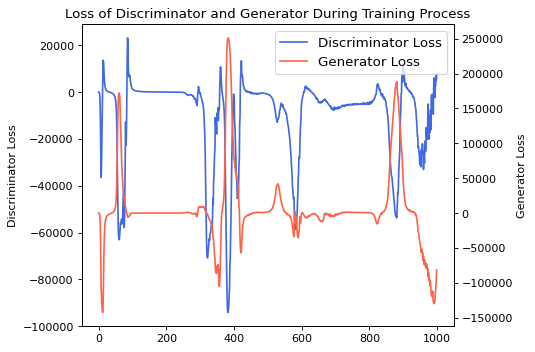

In [ ]:
MixedGAN_GC.show_train_process()

从上图中，我们能<font color=tomato>**明显观察到GAN网络中生成器$G$和判别器$D$互相对抗的更新过程，同时损失的极大波动也能看到GAN模型的训练困难.**</font>

保存模型，便于后续调用

In [ ]:
MixedGAN_GC.save_model("model/MixedGAN_GC/")

#### 2.2.2 基于Gradient Penalty的MixedGAN

创建Gradient Penalty模型，配置相应参数进行训练

In [ ]:
MixedGAN_GP = MixedGAN(scheme='WGAN_GP')
MixedGAN_GP.train(EPOCHS=1000,save_sample_gap=50,save_path="output/Pressure/WGAN_GP/",n_D=3)

100%|██████████| 1000/1000 [33:53<00:00,  2.03s/it]


绘制训练过程中损失的更新情况如下图所示

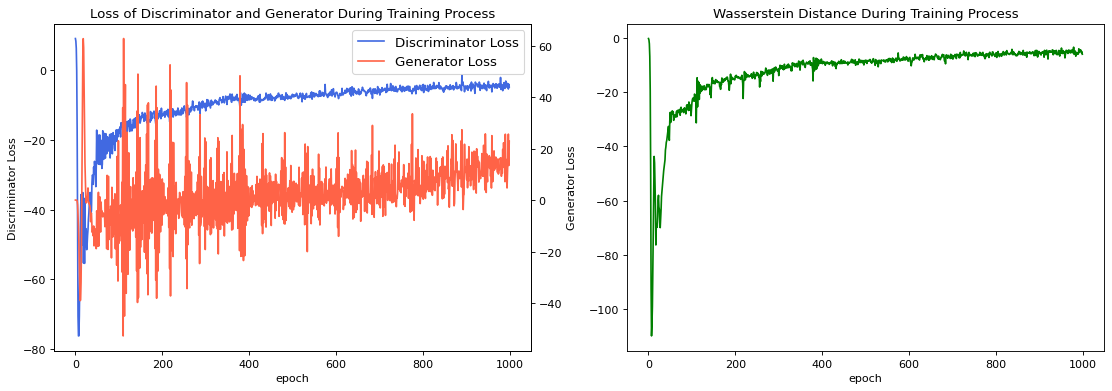

In [ ]:
MixedGAN_GP.show_train_process()

从上图中能够看到，<font color=tomato>**Gradient Penalty方法的更新较为平稳，判别器的损失收敛，生成器的损失规律波动**</font>  
此外，<font color=green>**对于Gradient Penalty方法，我们可以使用Wasserstein距离来判断网络的收敛情况**</font>，<font color=royalblue>**Wasserstein距离越接近0，说明网络收敛地越好**</font> 

<font color=tomato>**Gradient Penalty方法的Wasserstein距离是一个负数，从图中看到，随着训练的进行，Wasserstein距离逐渐增加，并稳定收敛靠近0**</font>

保存模型，便于后续调用

In [ ]:
MixedGAN_GP.save_model("model/MixedGAN_GP/")

#### 2.2.3 基于Wasserstein Loss的MixedGAN

创建Gradient Clipping模型，配置相应参数进行训练

In [ ]:
MixedGAN_WD = MixedGAN(scheme='WGAN_WD')
MixedGAN_WD.train(EPOCHS=1000,save_sample_gap=50,save_path="output/Pressure/WGAN_WD/",n_D=3)

100%|██████████| 1000/1000 [34:05<00:00,  2.05s/it]


绘制训练过程中损失的更新情况如下图所示

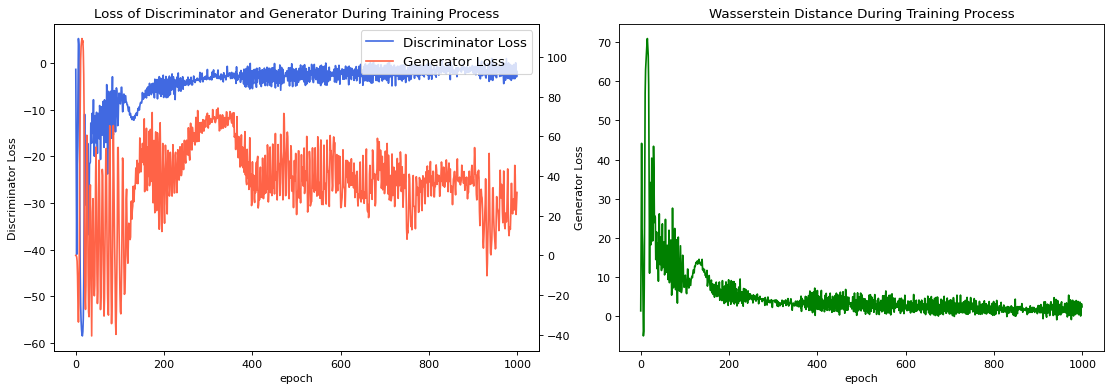

In [ ]:
MixedGAN_WD.show_train_process()

从上图中能够看到，<font color=tomato>**Wasserstein Loss方法的更新与Gradient Penalty方法比较相似，损失更新较为平稳，判别器的损失收敛，生成器的损失规律波动**</font>  
<font color=green>**对于Wasserstein Loss方法，我们也可以使用Wasserstein距离来判断网络的收敛情况**</font>，<font color=royalblue>**Wasserstein距离越接近0，说明网络收敛地越好**</font> 

<font color=tomato>**Wasserstein Loss方法的Wasserstein距离是一个正数，从图中看到，随着训练的进行，Wasserstein距离逐渐减小，并稳定收敛靠近0**</font>

保存模型，便于后续调用

In [ ]:
MixedGAN_WD.save_model("model/MixedGAN_WD/")

### 2.3 生成效果对比和MixedGAN模型选择

下面，我们考察三种不同MixedGAN网络在不同训练轮次时生成的压强场

In [ ]:
def compare_GAN(models : dict=None, gap : int=100):
    """
    绘制模型在训练过程中生成的压强场样例

    Parameters
    ----------
    models : dict
        按照(key,value) = (model_name : str, model : MixedGAN)的形式提供需要绘制的模型
    gap : int, optional
        每间隔多少轮训练绘制一张压强场样例，默认值100
    """
    if not models:
        models = {
            "Gradient Clipping": MixedGAN_GC,
            "Gradient Penalty": MixedGAN_GP,
            "Wasserstein Loss": MixedGAN_WD
        }
    xticks = np.arange(128)
    yticks = np.arange(64)
    for name,model in models.items():
        fig,ax = plt.subplots(2,5,figsize=(20,5),dpi=80)
        fig.suptitle("Pressure Generated in Different Training Rounds based on %s method"%(name),fontsize=12)
        ax = ax.flatten()
        for i in range(10):
            image = model.train_samples[i][0].squeeze()
            ax[i].contourf(xticks,yticks,image,cmap=plt.cm.rainbow,levels=15)
            ax[i].set_title("Generated Pressure at epoch=%d"%(gap*(i+1)))
        plt.tight_layout()

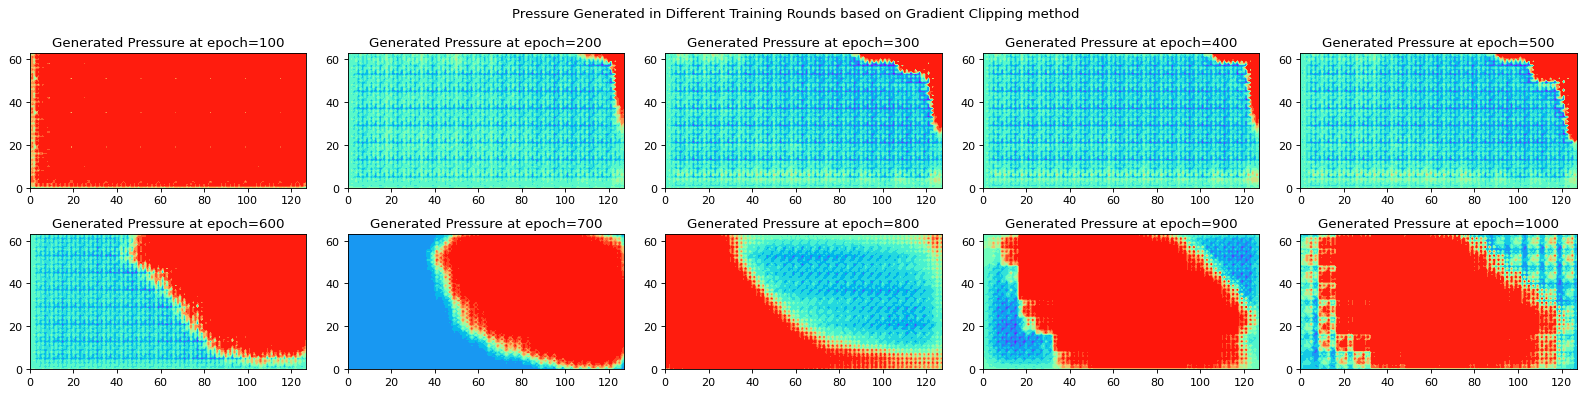

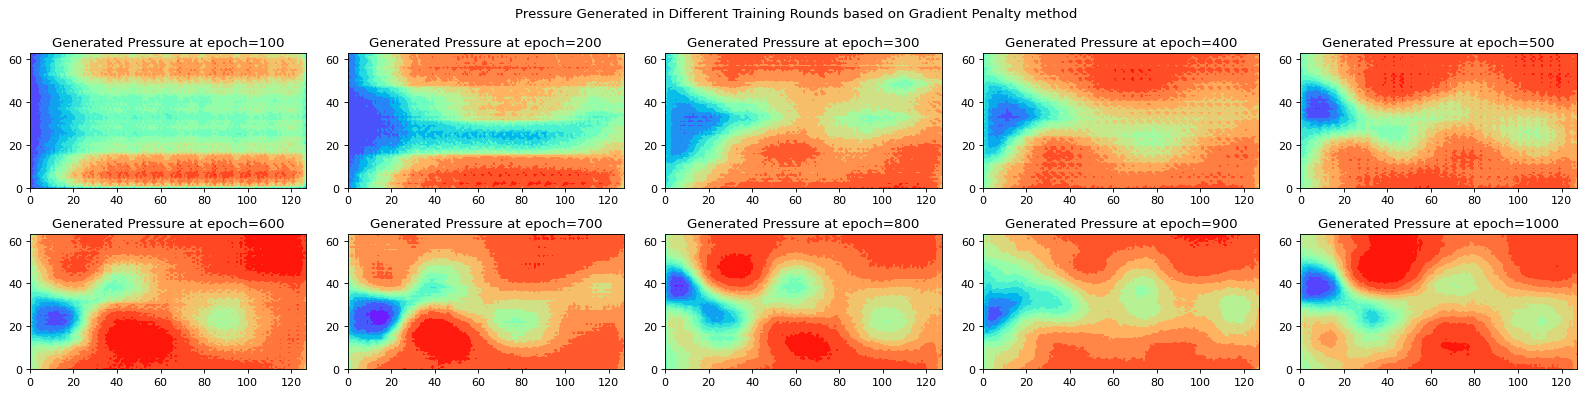

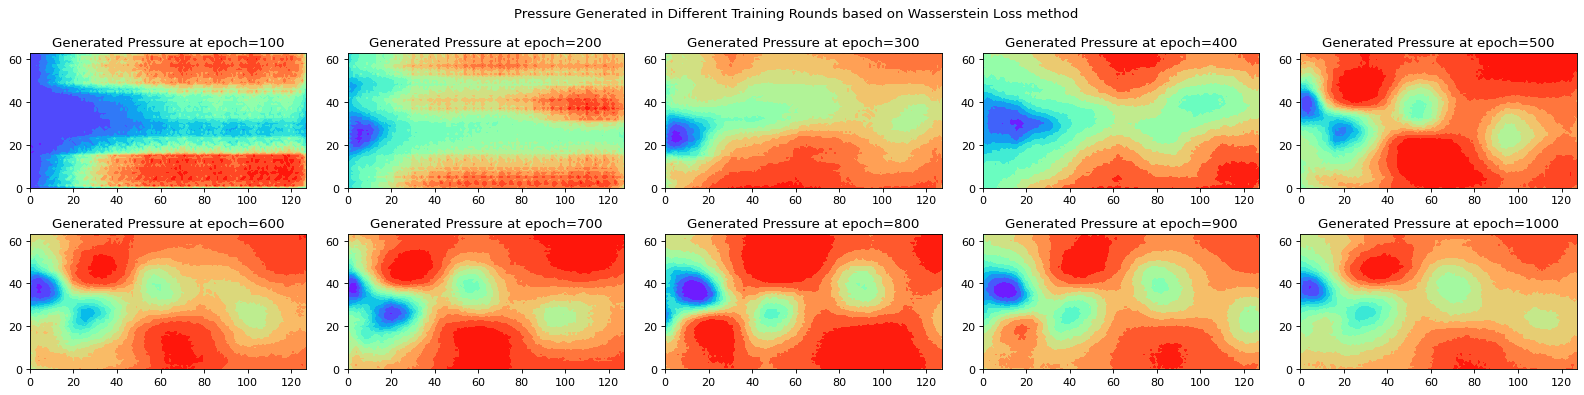

In [ ]:
compare_GAN()

从上图中的采样结果我们能够得到：
* <font color=tomato>**Gradient Clipping方法不稳定**</font>，无法正确学习到压强场的分布特征
* <font color=royalblue>**基于Gradient Penalty和Wasserstein Loss的MixedGAN均能正确学习到压强场的分布**</font>
* 在<font color=royalblue>**相同训练轮次条件下，基于Gradient Penalty生成的压强场比较"毛糙"，Wasserstein Loss方法生成的压强场更光滑，更接近真实压强场**</font>
* 基于Gradient Penalty和Wasserstein Loss的MixedGAN在<font color=royalblue>**进行1000轮训练后仍然未完全收敛**</font>，需要进行更多轮次的训练让模型收敛到更高精度

基于以上讨论的结果，我们<font color=tomato>**选择基于Wasserstein Loss方法的MixedGAN训练3000轮，并将其作为后续与LSTM配合所使用的GAN模型**</font>

In [ ]:
# 创建模型，训练3000轮确保收敛
MixedGAN_WD = MixedGAN(scheme='WGAN_WD')
MixedGAN_WD.train(EPOCHS=3000,save_sample_gap=50,save_path="output/Pressure/WGAN_WD/",n_D=3)
# 保存模型
MixedGAN_WD.save_model("model/MixedGAN_WD/")

100%|██████████| 3000/3000 [1:50:43<00:00,  2.21s/it]

----

## 3 GAN-LSTM模型

在这一节中，我们<font color=royalblue>**将之前训练好的GAN模型与LSTM模型结合，用于预测未来的压强场分布**</font><font color=blue>**[5]**</font>.

为了实现这一功能，我们需要使用<font color=tomato>**编码器-解码器模型的思想.**</font>   
一般而言，出于性能或处理便利的考虑，人们会使用编码器接收一个原始的输入，并经过编码器处理变换成为更容易处理的隐藏特征，隐藏特征经过运算送入至解码器得到人们希望的输出. 

<div align=center>
<img src="figure/解码器和编码器示意图.png" width=600 alt="解码器和编码器示意图">
</div>

针对压强场的预测，我们首先<font color=royalblue>**将图片展平为$64*128=8192$长的序列**</font>，<font color=tomato>**由于压强分布是连续变化的，如此长的序列中存在非常多的冗余信息，我们首先使用一个编码器将其编码为较短的隐序列送入LSTM**</font>

<font color=tomato>**LSTM作为中间过程的解码器**</font>，负责将编码后的短序列转换为我们关心的最后一层隐藏层最后时刻的输出，<font color=tomato>**但该输出并不能作为GAN模型的输入，因为序列维度并不匹配**</font>  
因此，<font color=royalblue>**我们使用第二个编码-解码器，将LSTM最后隐藏状态送入到编码器，编码器负责将隐藏层状态编码为符合GAN输入要求的序列，最后训练好的GAN作为解码器，利用编码后的序列生成未来压强场的预测.**</font>

<font color=green>**GAN-LSTM模型的示意图如下**</font>

<div align=center>
<img src="figure/GAN-LSTM编码解码器示意图.png" width=800 alt="GAN-LSTM编码解码器示意">
</div>

对于实现的具体细节，主要有以下几个方面：
* <font color=tomato>**两个编码器均为全连接神经网络**</font>，<font color=royalblue>**第一个编码器主要负责将长序列变短，减少信息冗余，提取关键特征，便于LSTM学习；第二个编码器主要负责将LSTM的隐藏层状态变换到GAN生成器所需要的输入维度**</font>
* <font color=tomato>**解码器LSTM的功能在于学习序列的时序特征，它并不需要生成图片**</font>
* 注意到<font color=tomato>**GAN只需要使用到生成器**</font>，因此在实现GAN-LSTM模型时，我们直接<font color=tomato>**将GAN中的生成器取出并拼接到LSTM和FCN2的后端**</font>，用于生成压强场的预测结果
* 在GAN-LSTM模型的训练过程中，<font color=tomato>**始终保持GAN的生成器$G$冻结，即GAN不参与GAN-LSTM的训练，GAN的训练放在它与LSTM拼接之前完成**</font>

对于为什么不拼接GAN和LSTM后一起训练，主要原因在于<font color=tomato>**GAN模型中包含深度卷积网络，其可训练参数数量远大于LSTM，让GAN与LSTM一起训练会导致LSTM的更新缓慢，无法学习到相应的时序信息，因此我们分两阶段进行训练.**</font>

<font color=royalblue>**我们使用AutoencoderLSTM作为与GAN-LSTM模型的对比**</font>，AutoencoderLSTM在实现上与GAN-LSTM的<font color=tomato>**区别在于其将LSTM的隐藏状态直接通过一个解码器映射为压强场序列，而没有使用GAN的生成能力.**</font>

<font color=green>**AutoencoderLSTM模型的示意图如下**</font>

<div align=center>
<img src="figure/AutoencoderLSTM编码解码器示意图.png" width=650 alt="AutoencoderLSTM编码解码器示意图">
</div>

最后，<font color=tomato>**关于压强场预测准确性的评估，我们使用L2相对误差**</font>，对于$t$时刻的真实压强场$P(x,y,t)$，以及时空序列模型对它的预测$\hat{P}(x,y,t)$，定义L2相对误差$L$为：
$$ L = \frac{\vert\vert P(x,y,t) - \hat{P}(x,y,t) \vert\vert_2 }{\vert\vert P(x,y,t) \vert\vert_2}. $$

<font color=royalblue>**L2相对误差$L\geq 0$，该误差越小，说明模型预测的结果越准确.**</font>

### 3.1 时空序列预测模型的搭建

我们分别创建两个基类`autoencoderLSTM`和`GAN_LSTM`用于实现上述功能，最后将它们封装到压强场的序列预测类`SpatiotemporalModel`当中，`SpatiotemporalModel`会实现除模型建立之外的其它功能

#### 3.1.1 AutoencoderLSTM

前面已经介绍过AutoencoderLSTM的实现原理了，  
<font color=royalblue>**我们首先使用一个全连接网络提取序列特征、去除冗余，再利用LSTM学习时序特征，最后用一个全连接网络将维度转换到压强场序列的大小作为预测的输出.**</font>

In [ ]:
# 自编码LSTM
class autoencoderLSTM(tf.keras.layers.Layer):
    """
    class autoencoderLSTM(num_hiddens : int=512, num_layers : int=1, **kwargs)
    |   AutoencoderLSTM类，继承自tf.keras.layers.Layer，基于自编码实现序列预测
    |   
    |   Parameters
    |   ----------
    |   num_hiddens : int, optional
    |       LSTM网络的隐藏状态的神经元数量，默认值512
    |   num_layers : int, optional
    |       LSTM网络的隐藏层个数，默认值1
    |   **kwargs
    |       其它构造keras.layers.Layer时需要传入的参数
    |
    |   Attributes
    |   ----------
    |   call(self, inputs, state)
    |       类的调用方法，给定输入和当前隐藏层状态进行计算和预测
    |   begin_state(self, *args, **kwargs)
    |       隐藏状态初始化方法，在训练或预测开始时，调用该方法获得初始隐藏状态
    |
    """
    def __init__(self, num_hiddens : int=512,num_layers : int=1, **kwargs) -> None:
        """
        __init__(self, num_hiddens : int=512,num_layers : int=1, **kwargs) -> None
            初始化构造函数
        
        Parameters
        ----------
        num_hiddens : int, optional
            LSTM网络的隐藏状态的神经元数量，默认值512
        num_layers : int, optional
            LSTM网络的隐藏层个数，默认值1
        **kwargs
            其它构造keras.layers.Layer时需要传入的参数
        """
        super(autoencoderLSTM, self).__init__(**kwargs)
        lstm_cell = [LSTMCell(num_hiddens, kernel_initializer='glorot_uniform') for i in range(num_layers)]
        rnn_layer = tf.keras.layers.RNN(lstm_cell, time_major=True, return_sequences=True, return_state=True)
        self.rnn = rnn_layer
        self.encoder_1 = Dense(2048,activation='relu')
        self.encoder_2 = Dense(512,activation='relu')
        self.decoder_1 = Dense(8192)

    def call(self, inputs : tf.Tensor, state : tf.Tensor) -> tuple:
        """
        call(self, inputs, state) -> tuple
            类的调用方法，给定输入和当前隐藏层状态进行计算和预测
        
        Parameters
        ----------
        inputs : tf.Tensor
            模型的输入，输入维度应该为(num_steps,batch_size,seq_size)
        state : tf.Tensor
            循环神经网络的隐藏状态，维度应该为(batch_size,num_hiddens)

        Return
        ----------
        (output, state) : tuple
            返回一个元组，第一个元素output是模型的预测输出，第二个元素是更新后的隐藏状态
        """
        num_steps = inputs.shape[0]
        batch_size = inputs.shape[1]
        FC1 = self.encoder_1(tf.reshape(inputs, (-1, inputs.shape[-1])))
        FC2 = self.encoder_2(FC1)
        Y, *state = self.rnn(tf.reshape(FC2, (num_steps,batch_size, FC2.shape[-1])), state)
        output = self.decoder_1(tf.reshape(Y, (-1, Y.shape[-1])))
        return output, state

    def begin_state(self, *args, **kwargs) -> tf.Tensor:
        """
        begin_state(self, *args, **kwargs) -> tf.Tensor
            隐藏状态初始化方法，在训练或预测开始时，调用该方法获得初始隐藏状态
        """
        return self.rnn.cell.get_initial_state(*args, **kwargs)

#### 3.1.2 GAN-LSTM

下面根据前面的介绍实现GAN-LSTM的基本框架.  
<font color=royalblue>**我们使用一个[8192->2048->512]的全连接网络作为特征提取的第一个编码器，再使用一个[512->100]的全连接网络作为编码器转换隐藏状态为GAN网络的输入**</font>

In [ ]:
class GAN_LSTM_Cell(tf.keras.layers.Layer):
    """
    class GAN_LSTM_Cell(num_hiddens : int=512, num_layers : int=1, generator : keras.models.Model=None, **kwargs)
    |   GAN-LSTM类，继承自tf.keras.layers.Layer，基于GAN和LSTM的时空序列预测类
    |   
    |   Parameters
    |   ----------
    |   num_hiddens : int, optional
    |       LSTM网络的隐藏状态的神经元数量，默认值512
    |   num_layers : int, optional
    |       LSTM网络的隐藏层个数，默认值1
    |   generator : keras.models.Model
    |       提供一个GAN网络的生成器
    |   encoder_layer : keras.models.Model
    |       从长序列到短序列的编码器层，默认值为None
    |   **kwargs
    |       其它构造keras.layers.Layer时需要传入的参数
    |
    |   Attributes
    |   ----------
    |   call(self, inputs, state)
    |       类的调用方法，给定输入和当前隐藏层状态进行计算和预测
    |   begin_state(self, *args, **kwargs)
    |       隐藏状态初始化方法，在训练或预测开始时，调用该方法获得初始隐藏状态
    |
    """
    def __init__(self, num_hiddens : int=512, num_layers : int=1, generator : keras.models.Model=None, 
                 encoder_layer : keras.models.Model=None, **kwargs) -> None:
        """
        __init__(self, num_hiddens : int=512, num_layers : int=1, generator : keras.models.Model=None, **kwargs) -> None
            初始化构造函数
        
        Parameters
        ----------
        num_hiddens : int, optional
            LSTM网络的隐藏状态的神经元数量，默认值512
        num_layers : int, optional
            LSTM网络的隐藏层个数，默认值1
        generator : keras.models.Model
            提供一个GAN网络的生成器
        encoder_layer : keras.models.Model
            从长序列到短序列的编码器层，默认值为None\n
            如果为None，则使用默认的编码器结构，该编码器由两层[2048->512]的全连接层组成
        **kwargs
            其它构造keras.layers.Layer时需要传入的参数
        """
        super(GAN_LSTM_Cell, self).__init__(**kwargs)
        lstm_cell = [LSTMCell(num_hiddens, kernel_initializer='glorot_uniform') for i in range(num_layers)]
        rnn_layer = tf.keras.layers.RNN(lstm_cell, time_major=True, return_sequences=True, return_state=True)
        self.rnn = rnn_layer
        self.encoder_layer = encoder_layer
        if not self.encoder_layer:
            # 编码序列向量，减少信息冗余
            self.encoder_layer = Sequential()
            self.encoder_layer.add(Dense(2048,activation='relu'))
            self.encoder_layer.add(Dense(512,activation='relu'))
        self.encoder_step_2_layer = Dense(100)
        # 生成器
        self.generator = generator
        # 冻结生成器
        self.generator.trainable = False
        
    def call(self, inputs : tf.Tensor, state : tf.Tensor) -> tuple:
        """
        call(self, inputs, state) -> tuple
            类的调用方法，给定输入和当前隐藏层状态进行计算和预测
        
        Parameters
        ----------
        inputs : tf.Tensor
            模型的输入，输入维度应该为(num_steps,batch_size,seq_size)
        state : tf.Tensor
            循环神经网络的隐藏状态，维度应该为(batch_size,num_hiddens)

        Return
        ----------
        (output, state) : tuple
            返回一个元组，第一个元素output是模型的预测输出，第二个元素是更新后的隐藏状态
        """
        num_steps = inputs.shape[0]
        batch_size = inputs.shape[1]
        input  = tf.reshape(inputs, (-1, inputs.shape[-1]))
        encode_step_1_output = self.encoder_layer(input)
        Y, *state = self.rnn(tf.reshape(encode_step_1_output, (num_steps,batch_size, encode_step_1_output.shape[-1])), state)
        encode_step_2_output = self.encoder_step_2_layer(tf.reshape(Y, (-1, Y.shape[-1])))
        image = self.generator(encode_step_2_output)
        output = tf.reshape(image, (image.shape[0],image.shape[1]*image.shape[2]))
        return output, state

    def begin_state(self, *args, **kwargs) -> tf.Tensor:
        """
        begin_state(self, *args, **kwargs) -> tf.Tensor
            隐藏状态初始化方法，在训练或预测开始时，调用该方法获得初始隐藏状态
        """
        return self.rnn.cell.get_initial_state(*args, **kwargs)

#### 3.1.3 组合时空序列模型

最后，<font color=royalblue>**将两个编写好的类封装到时空序列预测方法SpatiotemporalModel中，该方法还会提供模型的训练、预测和评估等功能**</font>

In [ ]:
class SpatiotemporalModel:
    """
    class SpatiotemporalModel(num_hiddens : int=256, num_layers : int=1, num_steps : int=5, seq_size : int=8192, scheme : str='GAN-LSTM', generator : keras.models.Model=None)
    |   时空序列预测类
    |   
    |   Parameters
    |   ----------
    |   num_hiddens : int, optional
    |       LSTM网络的隐藏状态的神经元数量，默认值256
    |   num_layers : int, optional
    |       LSTM网络的隐藏层个数，默认值1
    |   num_steps : int, optional
    |       时间序列预测所使用的滞后阶，默认值5
    |   seq_size : int, optional
    |       待处理的某个时刻序列的长度，默认值8192，即8192=64*128
    |   scheme : str, optional
    |       时空序列预测所使用的模型，取值['AutoencoderLSTM','GAN-LSTM']，默认值'GAN-LSTM'
    |   optimizer : str, optinal
    |       提供给模型训练的优化器，默认值为'adam'
    |   generator : keras.models.Model
    |       提供一个GAN网络的生成器
    |   encoder_layer : keras.models.Model
    |       提供给GAN-LSTM的从长序列到短序列的编码器层，默认值为None
    |
    |   Attributes
    |   ----------
    |   _buildLSTM(self) -> keras.models.Model
    |       类的调用方法，给定输入和当前隐藏层状态进行计算和预测
    |   train(self, EPOCHS : int=1000, batch_size : int=8, use_random_iter : bool=False, state : tf.Tensor=None):
    |   train_iter = SeqDataLoader(batch_size=batch_size,use_random_iter=use_random_iter,num_steps=self.num_steps)
    |       隐藏状态初始化方法，在训练或预测开始时，调用该方法获得初始隐藏状态
    |   predict(self,preinfo, num_preds : int=5) -> list
    |       给定历史信息preinfo，向后预测num_preds个时间处的未来序列
    |   evaluate(self,mode : str='valid', preinfo_steps : int=5, pred_steps : int=5) -> tf.Tensor
    |       评估预测值和真实值之间的L2相对误差
    |   show_train_process(self) -> None
    |       展示训练过程中损失和L2相对误差的变化情况
    |
    """
    def __init__(self,num_hiddens : int=256, num_layers : int=1, num_steps : int=5, seq_size : int=8192, 
                 optimizer : str='adam', scheme : str='GAN-LSTM', generator : keras.models.Model=None, encoder_layer : keras.models.Model=None) -> None:
        """
        __init__(self,num_hiddens : int=256, num_layers : int=1, num_steps : int=5, seq_size : int=8192, 
                 scheme : str='GAN-LSTM', generator : keras.models.Model=None) -> None
            初始化构造函数
        
        Parameters
        ----------
        num_hiddens : int, optional
            LSTM网络的隐藏状态的神经元数量，默认值256
        num_layers : int, optional
            LSTM网络的隐藏层个数，默认值1
        num_steps : int, optional
            时间序列预测所使用的滞后阶，默认值5
        seq_size : int, optional
            待处理的某个时刻序列的长度，默认值8192，即8192=64*128
        scheme : str, optional
            时空序列预测所使用的模型，取值['AutoencoderLSTM','GAN-LSTM']，默认值'GAN-LSTM'
        optimizer : str, optinal
            提供给模型训练所使用的优化器，默认值为'adam'
        generator : keras.models.Model
            提供一个GAN网络的生成器
        encoder_layer : keras.models.Model
            提供给GAN-LSTM的从长序列到短序列的编码器层，默认值为None\n
            如果为None，则使用默认的编码器结构，该编码器由两层[2048->512]的全连接层组成
        """
        self.seq_size = seq_size
        self.num_steps = num_steps
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.scheme = scheme
        self.generator = generator
        self.encoder_layer = encoder_layer
        self.lstm = self._buildLSTM()
        if optimizer == 'adam':
            self._optim = keras.optimizers.Adam(0.001)
        if optimizer == 'RMSprop':
            self._optim = keras.optimizers.RMSprop(0.001)
        if optimizer == 'SGD':
            self._optim = keras.optimizers.SGD(0.01)
        self.history = {
            "loss": [],
            "L2 relative error": [],
        }
    
    def _buildLSTM(self) -> keras.models.Model:
        """
        _buildLSTM(self) -> keras.models.Model:
            根据所提供的方案，构造LSTM预测模型
        """
        if self.scheme == 'AutoencoderLSTM':
            model = autoencoderLSTM(self.num_hiddens,self.num_layers)
        if self.scheme == 'GAN-LSTM':
            model = GAN_LSTM_Cell(num_hiddens=self.num_hiddens, num_layers=self.num_layers, generator=self.generator,encoder_layer=self.encoder_layer)
        return model

    def train(self, EPOCHS : int=1000, batch_size : int=8, learning_rate : float=0.001, 
              use_random_iter : bool=False, state : tf.Tensor=None, train_size : float=0.8, verbose : bool=True) -> None:
        """
        train(self, EPOCHS : int=1000, batch_size : int=8, use_random_iter : bool=False, state : tf.Tensor=None)
            时空序列预测模型训练函数
        
        Parameters
        ----------
        EPOCHS : int, optional
            总迭代次数，默认值1000
        batch_size : int, optional
            批量大小，默认值8
        learning_rate : float, optional
            设置优化器的学习率，默认值0.001
        use_random_iter : bool, optional
            生成批量数据时是否随机打乱，默认值False
        state : tf.Tensor, optional
            提供一个已有的隐藏状态，默认值为None\n
            如果不提供，或者use_random_iter=True，则每轮训练都会调用self.lstm.begin_state方法获得初始状态
        train_size : float, optional
            训练集在整个数据集中所占的比例，默认值0.8\n
            由于训练数据是时序数据，因此训练集只会从序列数据的头部开始拿取
        verbose : bool, optional
            是否打印损失函数的相关信息
        """
        train_iter = SeqDataLoader(batch_size=batch_size,use_random_iter=use_random_iter,num_steps=self.num_steps,train_size=train_size)
        self._optim.learning_rate = learning_rate
        for epoch in range(EPOCHS):
            for X,y in train_iter:
                if state is None or use_random_iter:
                    # 在第一次迭代或使用随机抽样时初始化state
                    state = self.lstm.begin_state(batch_size=X.shape[1], dtype=tf.float32)
                with tf.GradientTape(persistent=True) as tape:
                    y_hat, state = self.lstm(X, state)
                    y = tf.reshape(y, (-1, y.shape[-1]))
                    loss = tf.reduce_mean((y_hat-y)**2)
                params = self.lstm.trainable_variables
                grads = tape.gradient(loss, params)
                self._optim.apply_gradients(zip(grads, params))
            l2_relative_err = self.evaluate(mode='valid',preinfo_steps=5,pred_steps=5)[0]
            self.history["L2 relative error"].append(l2_relative_err)
            self.history["loss"].append(loss)
            if (epoch+1)%50 == 0 and verbose:
                print("epoch: %d\tloss: %.6f\t\tL2 relative error: %.6f"%(epoch+1,loss,l2_relative_err))
    
    def predict(self,preinfo : tf.Tensor, num_preds : int=5) -> list:
        """
        predict(self,preinfo, num_preds : int=5) -> list
            给定历史信息preinfo，向后预测num_preds个时间处的未来序列
        
        Parameters
        ----------
        preinfo : tf.Tensor
            序列的历史信息
        num_preds : int, optional
            向后预测的阶数，默认值5

        Return
        ----------
        outputs : list
            返回list，list的前一部分元素时predinfo，后一部分元素是预测得到的未来num_steps阶的序列
        """
        state = self.lstm.begin_state(batch_size=1, dtype=tf.float32)
        outputs = [preinfo[0]]
        get_input = lambda: tf.reshape(outputs[-1],(1, 1, self.seq_size))
        # 预热期
        for y in preinfo[1:]:  
            _, state = self.lstm(get_input(), state)
            outputs.append(y)
        # 预测num_preds步
        for _ in range(num_preds):  
            y, state = self.lstm(get_input(), state)
            outputs.append(y)
        return outputs
    
    def evaluate(self,mode : str='valid', preinfo_steps : int=5, pred_steps : int=5) -> tuple:
        """
        evaluate(self,mode : str='valid', preinfo_steps : int=5, pred_steps : int=5) -> tf.Tensor
            评估预测值和真实值之间的L2相对误差
        
        Parameters
        ----------
        mode : str, optional
            评估验证集还是评估测试集，取值['valid','test']，默认值'valid'
        preinfo_steps : int, optional
            前置历史信息的阶数，默认值5，表示提供前5个时刻的序列供模型预测
        pred_steps : int, optional
            向后预测的阶数，默认值5，表示评估模型向后预测5步的误差

        Return
        ----------
        (tf.reduce_mean(l2_relative_err), l2_relative_err) : tuple
            返回tuple，tuple的第一个元素是未来num_steps的L2相对误差的均值\n
            第二个元素是tf.Tensor，它包含了未来num_steps各个时刻的L2相对误差
        """
        data_iter = SeqDataLoader(batch_size=1,num_steps=5,use_random_iter=False,datasets=mode,preinfo_steps=preinfo_steps,pred_steps=pred_steps)
        for X,y_true in data_iter:
            y_true = tf.reshape(y_true,(pred_steps,y_true.shape[-1]))
            y_pred = self.predict(X,pred_steps)[preinfo_steps:]
            y_pred = tf.concat(y_pred, axis=0)
            # 返回范数相对误差
            l2_relative_err = tf.norm(y_pred - y_true,axis=1) / tf.norm(y_true,axis=1)
            return tf.reduce_mean(l2_relative_err), l2_relative_err
    
    def show_train_process(self) -> None:
        """
        show_train_process(self) -> None
            展示训练过程
        """
        fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=80)
        ax = ax.flatten()
        xticks = range(len(self.history["loss"]))
        ax[0].plot(xticks,self.history["loss"],color="royalblue",label="loss")
        ax[0].set_yscale('log')
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel("loss")
        ax[0].set_title("Loss During Training Process")
        ax[0].legend()
        ax[1].plot(xticks,self.history["L2 relative error"],color="tomato",label="L2 relative error")
        ax[1].set_ylabel("L2 relative error")
        ax[1].set_xlabel("epoch")
        ax[1].set_title("Metrics During Training Process")
        ax[1].legend()
        plt.tight_layout()
    
    def show_ground_truth(self) -> None:
        """
        show_ground_truth(self) -> None
            绘制预测结果，让预测结果与ground truth进行对比
        """
        test_iter = SeqDataLoader(batch_size=1,num_steps=5,use_random_iter=False,datasets='test',preinfo_steps=5,pred_steps=5)
        for X_test,y_test in test_iter:
            y_test = tf.reshape(y_test,(5,y_test.shape[-1]))
            y_pred = self.predict(X_test)[5:]
            y_pred = tf.concat(y_pred, axis=0)
            break
        data = {
            "History Information": X_test,
            "Ground Truth": y_test,
            "Predictions": y_pred
        }
        xticks = np.arange(128)
        yticks = np.arange(64)
        for name,images in data.items():
            fig,ax = plt.subplots(1,5,figsize=(18,3),dpi=80)
            fig.suptitle(name)
            ax = ax.flatten()
            for i,image in enumerate(images):
                if name in ["Ground Truth","Predictions"]:
                    image = np.reshape(image,(64,128))
                else:
                    image = np.reshape(image[0],(64,128))
                ax[i].contourf(xticks,yticks,image,cmap=plt.cm.rainbow,levels=15)
                if name == "History Information":
                    ax[i].set_title("Pressure at $T=t-%d$\n(%s)"%(5-i,name))
                else:
                    if i == 0:
                        ax[i].set_title("Pressure at $T=t$\n(%s)"%(name))
                    else:
                        ax[i].set_title("Pressure at $T=t+%d$\n(%s)"%(i,name))
            plt.tight_layout()


### 3.2 模型的训练

<font color=royalblue>**下面，我们按照如下配置方案训练AutoencoderLSTM和GAN-LSTM模型**</font>

<style>
table {
margin: auto;
}
</style>
| 模型 | 迭代次数EPOCHS | batch_size | 优化器 | 学习率 | num_steps | LSTM隐藏层大小num_layers |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| <div style="height: 20pt; line-height:20px">AutoencoderLSTM</div> | 1000 | 8 | Adam | 0.001 | 8 | 1 |
| <div style="height: 20pt; line-height:20px">GAN-LSTM</div> | 1000 | 8 | Adam | 0.001 | 8 | 1 |

#### 3.2.1 基于AutoencoderLSTM

In [ ]:
AutoencoderLSTM_model = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='AutoencoderLSTM',generator=None)
AutoencoderLSTM_model.train(EPOCHS=1000,batch_size=8,use_random_iter=False)

epoch: 50	loss: 0.030190		L2 relative error: 0.349946
epoch: 100	loss: 0.026895		L2 relative error: 0.329437
epoch: 150	loss: 0.026227		L2 relative error: 0.335443
epoch: 200	loss: 0.023192		L2 relative error: 0.342764
epoch: 250	loss: 0.026380		L2 relative error: 0.345147
epoch: 300	loss: 0.019303		L2 relative error: 0.343989
epoch: 350	loss: 0.018229		L2 relative error: 0.346104
epoch: 400	loss: 0.018181		L2 relative error: 0.348664
epoch: 450	loss: 0.016133		L2 relative error: 0.330539
epoch: 500	loss: 0.016842		L2 relative error: 0.312691
epoch: 550	loss: 0.015233		L2 relative error: 0.314450
epoch: 600	loss: 0.015377		L2 relative error: 0.392504
epoch: 650	loss: 0.013342		L2 relative error: 0.295500
epoch: 700	loss: 0.021514		L2 relative error: 0.309117
epoch: 750	loss: 0.017442		L2 relative error: 0.283685
epoch: 800	loss: 0.017535		L2 relative error: 0.362106
epoch: 850	loss: 0.011586		L2 relative error: 0.390302
epoch: 900	loss: 0.013980		L2 relative error: 0.280727
epoch: 950	

绘制训练过程中损失和L2相对误差的更新情况如下所示

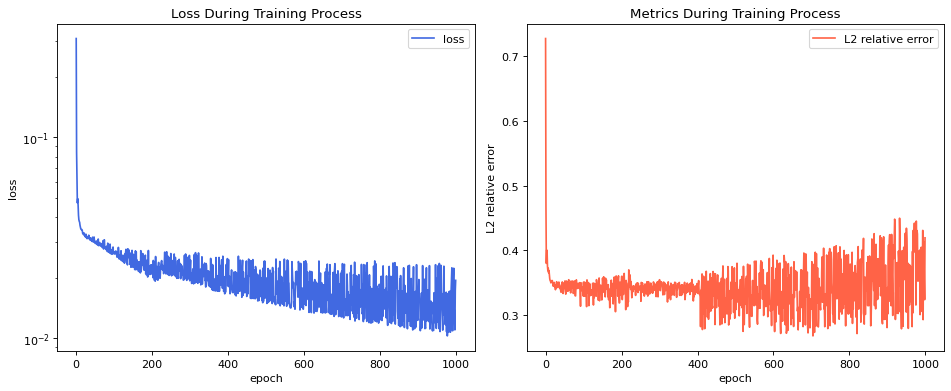

In [ ]:
AutoencoderLSTM_model.show_train_process()

从损失和L2相对误差的更新可以看到，<font color=tomato>**模型在训练中后期出现明显的振荡，L2相对误差偏高**</font>，<font color=royalblue>**模型的收敛性较差，会使得最终的预测效果不符合预期**</font>


#### 3.2.2 基于GAN-LSTM

In [ ]:
GAN_LSTM_model = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
GAN_LSTM_model.train(EPOCHS=1000,batch_size=8, use_random_iter=False)

epoch: 50	loss: 0.004017		L2 relative error: 0.468111
epoch: 100	loss: 0.001429		L2 relative error: 0.529523
epoch: 150	loss: 0.000720		L2 relative error: 0.481380
epoch: 200	loss: 0.000603		L2 relative error: 0.454896
epoch: 250	loss: 0.000975		L2 relative error: 0.158357
epoch: 300	loss: 0.000907		L2 relative error: 0.514162
epoch: 350	loss: 0.000406		L2 relative error: 0.244257
epoch: 400	loss: 0.000363		L2 relative error: 0.240630
epoch: 450	loss: 0.000515		L2 relative error: 0.390323
epoch: 500	loss: 0.000340		L2 relative error: 0.441640
epoch: 550	loss: 0.000315		L2 relative error: 0.468009
epoch: 600	loss: 0.000754		L2 relative error: 0.333411
epoch: 650	loss: 0.000294		L2 relative error: 0.438252
epoch: 700	loss: 0.000450		L2 relative error: 0.411416
epoch: 750	loss: 0.000319		L2 relative error: 0.419669
epoch: 800	loss: 0.000357		L2 relative error: 0.411180
epoch: 850	loss: 0.000471		L2 relative error: 0.395248
epoch: 900	loss: 0.000465		L2 relative error: 0.427821
epoch: 950	

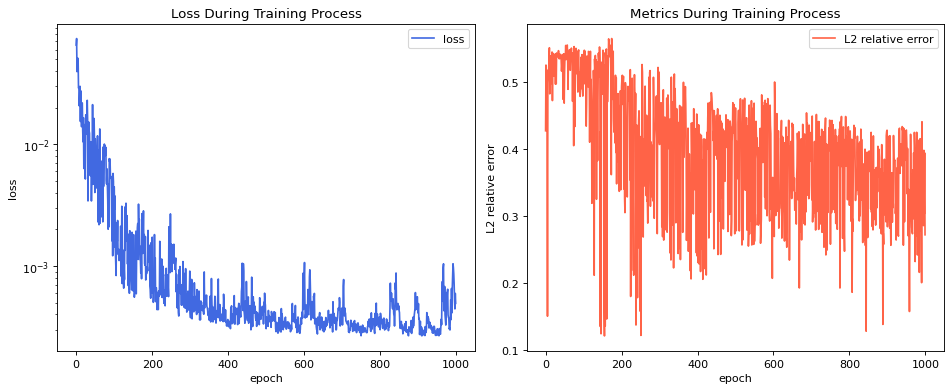

In [ ]:
GAN_LSTM_model.show_train_process()

从损失和L2相对误差的更新可以看到，<font color=tomato>**模型在训练中损失一直在减小并有收敛趋势，但L2相对误差振荡明显**</font>，<font color=royalblue>**这可能是由于学习率过高导致模型更新不稳定**</font>


<font color=tomato>**相比AutoencoderLSTM，借助了GAN的生成能力，GAN-LSTM的损失是收敛的**</font>，下面我们将预测结果与Ground Truth进行比对，进一步讨论两个模型的性能

### 3.3 模型预测效果评估

上一节中，我们看到<font color=tomato>**AutoencoderLSTM与GAN-LSTM在相同网络配置参属下，GAN-LSTM的损失收敛性更好**</font>  
下面，我们<font color=royalblue>**分别提供给模型过去5个时间点的历史压强场信息，让它们推断预测未来5个时间点的压强场分布，并与未来时间点处的真实压强场(即Ground Truth)分布进行对比**</font>

**(1) AutoencoderLSTM**

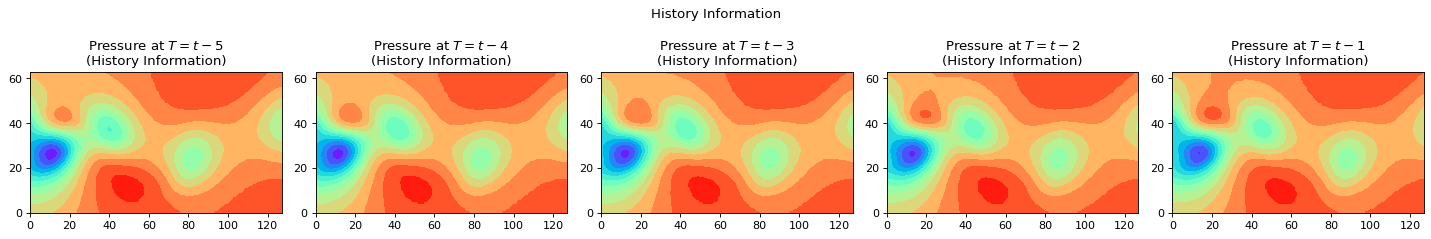

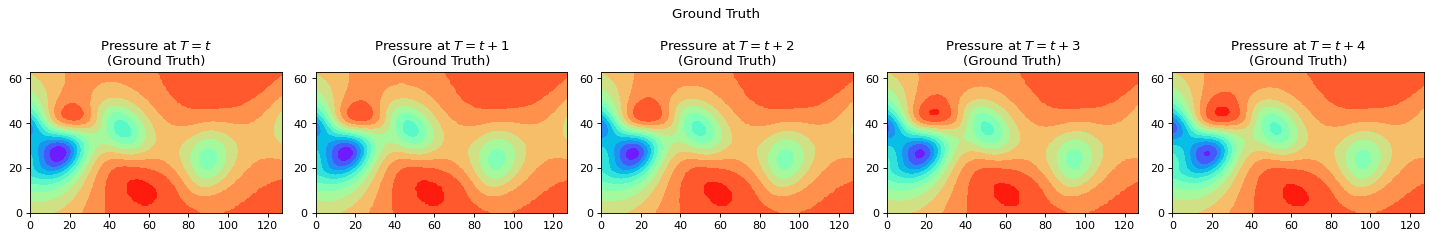

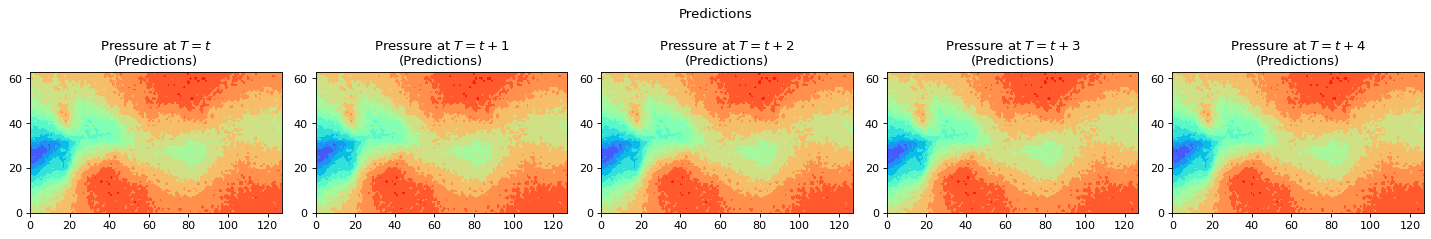

In [ ]:
AutoencoderLSTM_model.show_ground_truth()

从预测结果来看：
* <font color=royalblue>**AutoencoderLSTM只能学习获得压强场的大致分布信息，其对压强场的预测存在大量噪声，压强场的解码是不准确的**</font>
* <font color=royalblue>**我们无法从含有大量噪点的分布中判断模型是否正确预测了未来压强场的分布**</font>

**(2) GAN-LSTM**

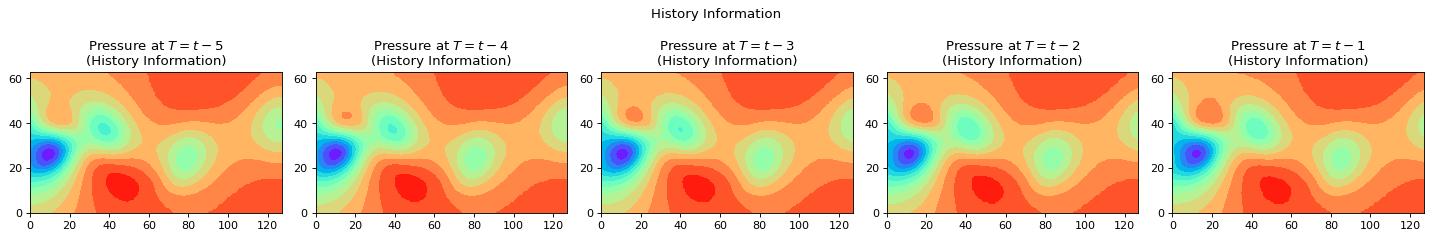

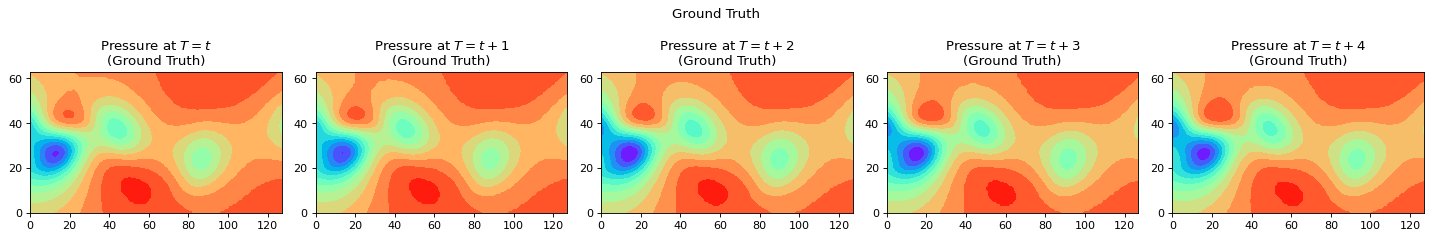

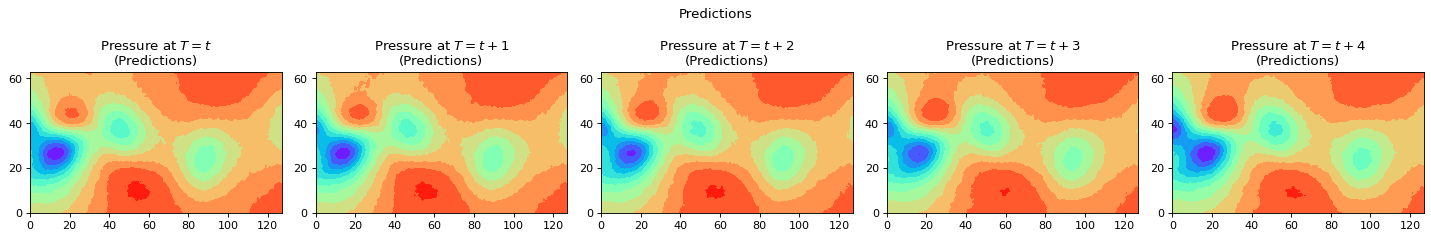

In [ ]:
GAN_LSTM_model.show_ground_truth()

从预测结果来看：
* <font color=green>**GAN的生成器$G$为GAN-LSTM提供了良好的解码器，它能正确并精准地表达压强场的分布特征，而不像AutoencoderLSTM会生成含有大量噪声的预测**</font>
* <font color=royalblue>**未来的预测结果与Ground Truth的对比看到，模型的预测能正确地表示未来压强场的分布特征**</font>

关于时序信息预测的细节，通过两个例子稍做解释如下：
* <font color=royalblue>**在Ground Truth图中，随着时间的推移，最右侧的一个低压中心在不断向右偏移，直至$T=t+4$时完全消失**</font>，<font color=tomato>**在Predictions图中，模型正确表现了上述低压中心的移动特征**</font>
* <font color=royalblue>**在Ground Truth图中，随着时间的推移，我们能观察到靠近左上角的趋于内一个高压中心的生成过程**</font>，<font color=tomato>**在Predictions图中，同样的生成过程得以体现**</font>

下面，我们<font color=tomato>**将在上面的GAN-LSTM模型作为Baseline Model，在其基础上讨论其网络设计、配置和训练方面的调优工作**</font>

----

## 4 模型调优

我们将主要从<font color=royalblue>**编码器结构、LSTM隐藏层数量、学习率、优化器、所提供的历史信息长度(num_steps)、训练序列生成方式**</font>讨论网络调优

每次调优，我们均<font color=tomato>**固定其它参数不改变，采用贪心方法寻找最优配置方案**</font>

### 4.1 学习率调优

在3.2节的实验中，我们观察到在默认学习率0.001下，<font color=tomato>**GAN-LSTM的损失更新和在验证集上的相对误差有明显震荡**</font>  
因此，<font color=royalblue>**我们在这一节考虑调低学习率，分别尝试设置学习率为0.0005，0.0001和0.00001**</font>

**(1) 学习率等于0.0005**

In [ ]:
model_lr_1 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_lr_1.train(EPOCHS=1000,batch_size=8,learning_rate=0.0005, use_random_iter=False,verbose=False)

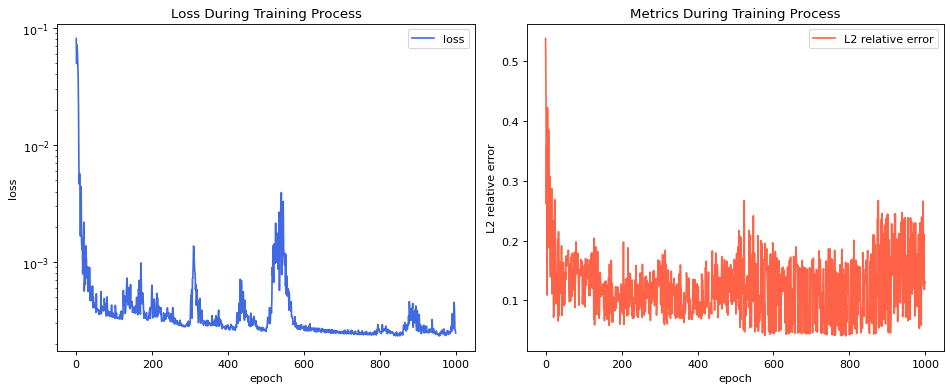

In [ ]:
model_lr_1.show_train_process()

**(2) 学习率等于0.0001**

In [ ]:
model_lr_2 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_lr_2.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

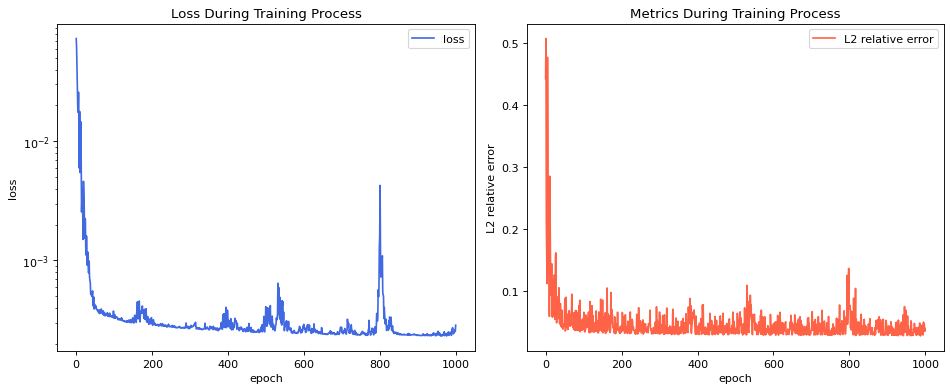

In [ ]:
model_lr_2.show_train_process()

**(3) 学习率等于0.00001**

In [ ]:
model_lr_3 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_lr_3.train(EPOCHS=1000,batch_size=8,learning_rate=0.00001, use_random_iter=False,verbose=False)

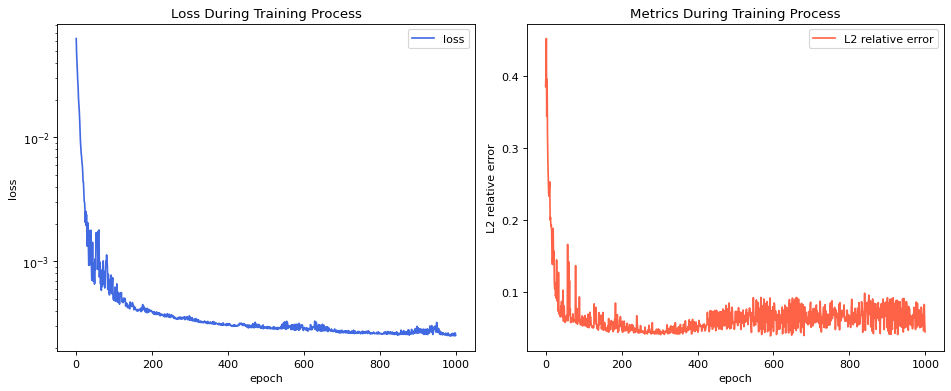

In [ ]:
model_lr_3.show_train_process()

从下面的结果我们可以发现：
* <font color=tomato>**三种学习率方案都减小了模型更新的震荡，模型在测试集上的L2相对误差大幅下降并趋于平稳**</font>
* <font color=royalblue>**从损失的更新情况观察、1000次迭代能使模型基本收敛**</font>

<font color=green>**下面，我们考虑三种方案、模型在测试集上不同预测步长的表现**

首先<font color=royalblue>**定义一个评估函数`L2_relative_error_over_time`**</font>，它将<font color=tomato>**绘制L2相对误差随着未来预测阶数的变化情况，用于比较各个模型性能**</font>

In [ ]:
def L2_relative_error_over_time(models : dict=None, preinfo_steps : int=8, pred_steps : int=8, hyperparameter : str=None, use_log : bool=False) -> None:
    """
    L2_relative_error_over_time(models : dict=None, preinfo_steps : int=5, pred_steps : int=5, hyperparameter : str=None) -> None
        测试验证评估函数，给定一个模型字典，评估这些模型在预测未来压强分布时的L2相对误差表现
    models : dict
        等待评估的模型，请提供一个字典，其中键值对(key,value)表示对应模型的名字或标签key和GAN-LSTM模型本身
    preinfo_steps : int, optional
        前置历史信息的阶数，默认值5，表示提供前5个时刻的序列供模型预测
    pred_steps : int, optional
        向后预测的阶数，默认值5，表示评估模型向后预测5步的误差
    hyperparameter : str, optional
        所测试模型的超参数，默认值为None
    use_log : bool, optional
        是否对纵坐标进行对数变换，默认值False
    """
    fig = plt.figure(figsize=(8,5),dpi=90)
    xticks = range(1,pred_steps+1)
    for name,model in models.items():
        L2_relative_error = model.evaluate(mode='test', preinfo_steps=preinfo_steps, pred_steps=pred_steps)[1]
        plt.plot(xticks,L2_relative_error,'o',ls='--',label=name)
    plt.xticks(xticks,labels=["T+%d"%(i) for i in xticks])
    plt.xlabel("Prediction Order (Future Time Point)")
    plt.ylabel("L2 Relative Error")
    plt.title("Relationship between L2 Relative Error and Prediction Order\n(Hyperparameter: %s)"%(hyperparameter))
    if use_log:
        plt.yscale('log')
        plt.yticks([1e-1,1e-2])
    plt.legend()

我们<font color=tomato>**为模型提供向前8个单位的历史压强信息，让它们预测未来8个时间节点处的压强场分布，观察L2相对误差的变化情况**</font>

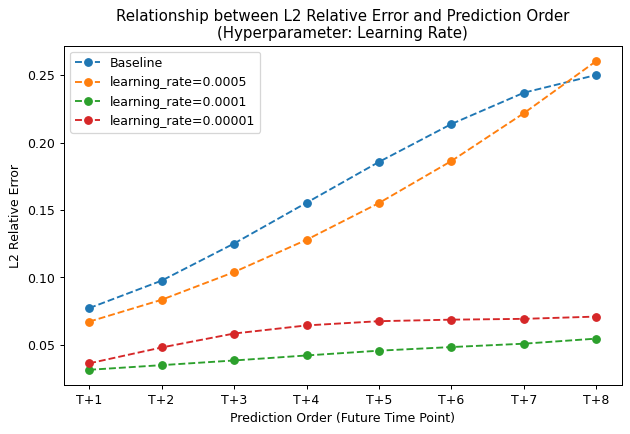

In [ ]:
models = {
    "Baseline": GAN_LSTM_model,
    "learning_rate=0.0005": model_lr_1,
    "learning_rate=0.0001": model_lr_2,
    "learning_rate=0.00001": model_lr_3,
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Learning Rate')

分析上图中的结果，我们能看到：
* <font color=royalblue>**学习率的下降，让各模型的预测性能相比Baseline均有提升**</font>，低学习率有助于让GAN-LSTM模型更新更平稳
* 针对该问题，<font color=tomato>**最优学习率应该设置为0.0001**</font>
* <font color=royalblue>**学习率太小让模型更新速度太慢，L2相对误差反而上升**</font>
* <font color=tomato>**模型的L2相对误差整体随预测阶数增加而增大**</font>，但对于收敛性较好的模型，<font color=tomato>**误差增大幅度小且平稳，模型预测未来信息的鲁棒性强**</font>

### 4.2 优化器的选择

下面，我们<font color=royalblue>**统一学习率为0.0001，并考虑三种不同的优化器：Adam，RMSprop和SGD**</fonr>

**(1) Adan**

<font color=purple>**(注：4.1节中的模型`model_lr_2`使用了Adam优化器，并且学习率设置为了0.0001，因此不必重复进行实验)**</font>

**(2) RMSprop**

In [ ]:
model_optim_rmsp = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator,optimizer='RMSprop')
model_optim_rmsp.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

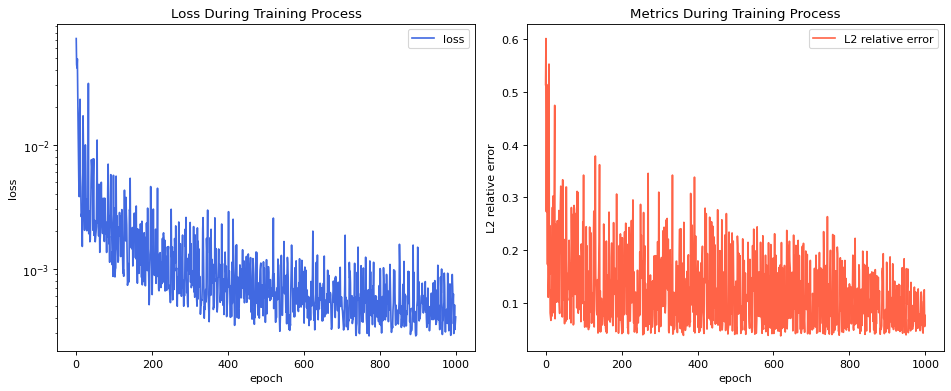

In [ ]:
model_optim_rmsp.show_train_process()

<font color=royalblue>**我们观察到RSMprop优化器更新过程中的震荡现象，考虑降低学习率到0.00001，重新训练确保模型收敛到该优化器的最优结果**</font>

In [ ]:
model_optim_rmsp = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator,optimizer='RMSprop')
model_optim_rmsp.train(EPOCHS=1000,batch_size=8,learning_rate=0.00001, use_random_iter=False,verbose=False)

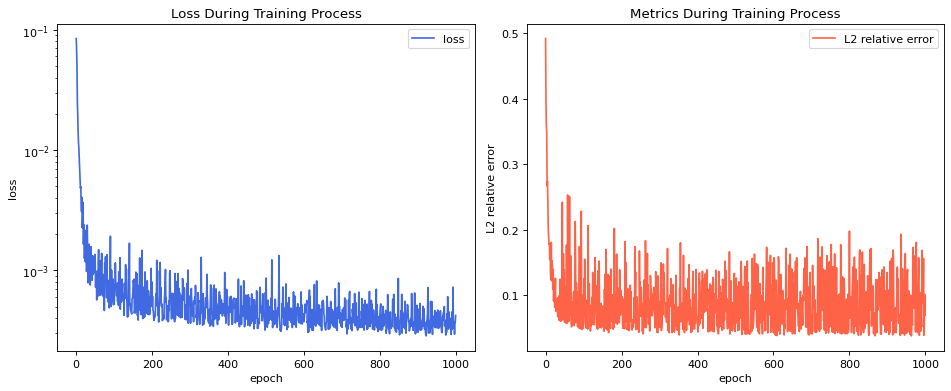

In [ ]:
model_optim_rmsp.show_train_process()

**(3) SGD**

<font color=purple>**(注：SGD优化器不宜使用Adam优化器中0.0001如此小的学习率，我们增大SGD优化器的学习率到0.005，并增加迭代次数到1500确保收敛)**</font>

In [ ]:
model_optim_sgd = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator,optimizer='SGD')
model_optim_sgd.train(EPOCHS=1500,batch_size=8,learning_rate=0.005, use_random_iter=False,verbose=False)

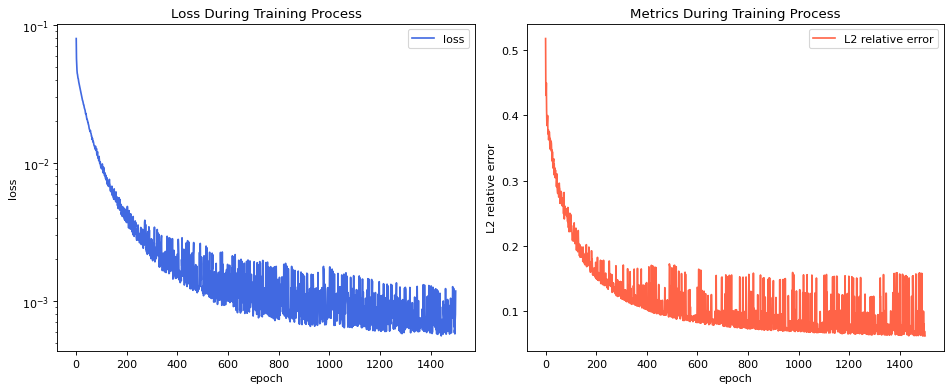

In [ ]:
model_optim_sgd.show_train_process()

我们<font color=tomato>**考虑模型在预测未来时的表现**</font>

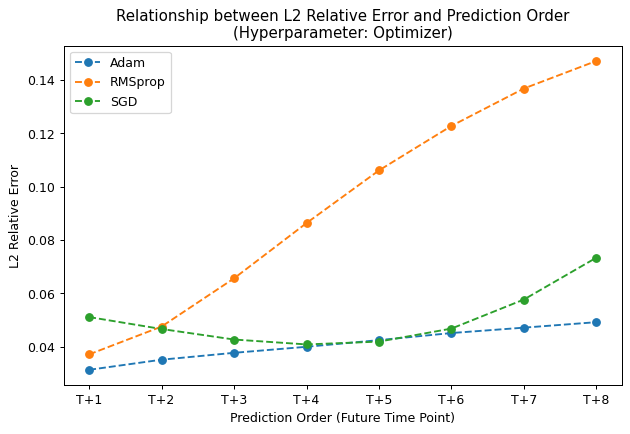

In [ ]:
models = {
    "Adam": model_lr_2,
    "RMSprop": model_optim_rmsp,
    "SGD":model_optim_sgd,
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Optimizer')

分析上图中的结果，我们能看到：
* <font color=tomato>**模型的L2相对误差整体随预测阶数增加而增大**</font>
* <font color=royalblue>**Adam和SGD的性能接近，Adam略优于SGD，且L2相对误差随预测阶数增加的增大不显著，模型预测未来的鲁棒性强**</font>  
* <font color=tomato>**RSMprop优化的性质在一开始与Adam和SGD接近，但其L2相对误差随预测阶数增加的增大很显著（从0.04至0.14），使用RSMprop优化器的模型预测鲁棒性不如Adam和SGD**</font>

### 4.3 编码器的设计

在将长序列编码为短序列送入到LSTM网络中时，<font color=tomato>**默认的编码器为一个简单的全连接网络[8192->2048->512]**</font>  
下面我们<font color=royalblue>**考虑缩小或增加编码器的规模，并考虑在编码器中加入BatchNormalization**</font>

根据4.1节和4.2节的研究结果，<font color=royalblue>**模型训练使用Adam优化器，学习率设置为0.0001**</font>

**(1) 全连接网络[8192->512]**

In [ ]:
encoder_structure = keras.Sequential(
    Dense(512,activation='relu')
)
model_encoder_1 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',
                                      generator=MixedGAN_WD.generator,encoder_layer=encoder_structure)
model_encoder_1.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

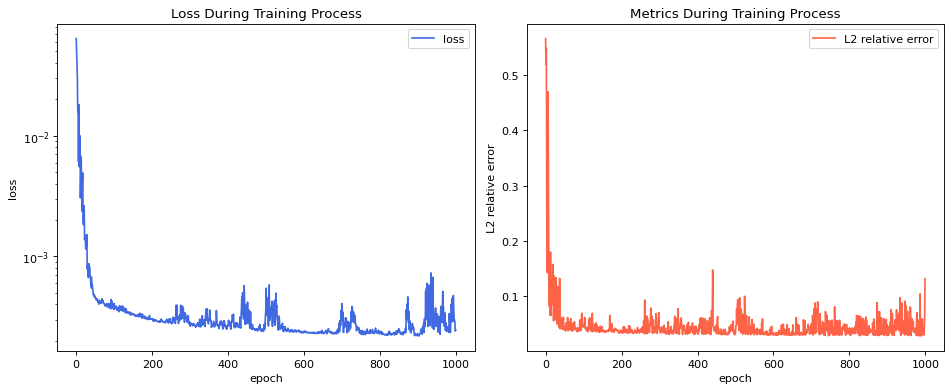

In [ ]:
model_encoder_1.show_train_process()

**(2) 全连接网络[8192->512]，使用BatchNormalization**

In [ ]:
encoder_structure = keras.Sequential([
    Dense(512),
    BatchNormalization(),
    Activation('relu')
])
model_encoder_2 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',
                                      generator=MixedGAN_WD.generator,encoder_layer=encoder_structure)
model_encoder_2.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

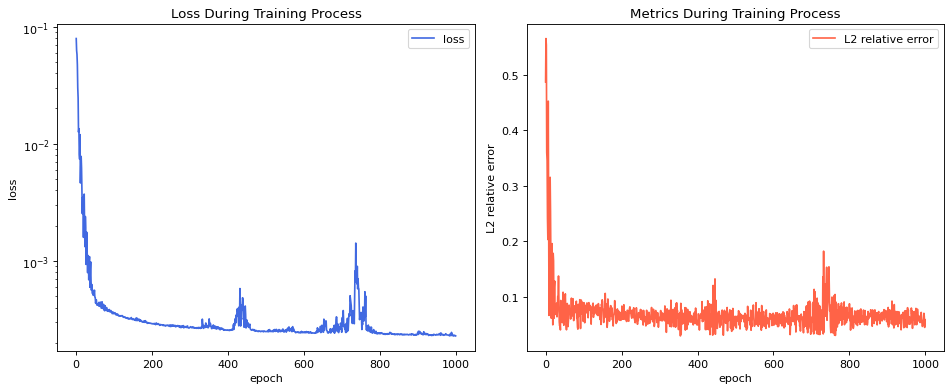

In [ ]:
model_encoder_2.show_train_process()

**(3) 全连接网络[8192->4096->2048->512]**

In [ ]:
encoder_structure = keras.Sequential([
    Dense(4096,activation='relu'),
    Dense(2048,activation='relu'),
    Dense(512,activation='relu')
])
model_encoder_3 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',
                                      generator=MixedGAN_WD.generator,encoder_layer=encoder_structure)
model_encoder_3.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

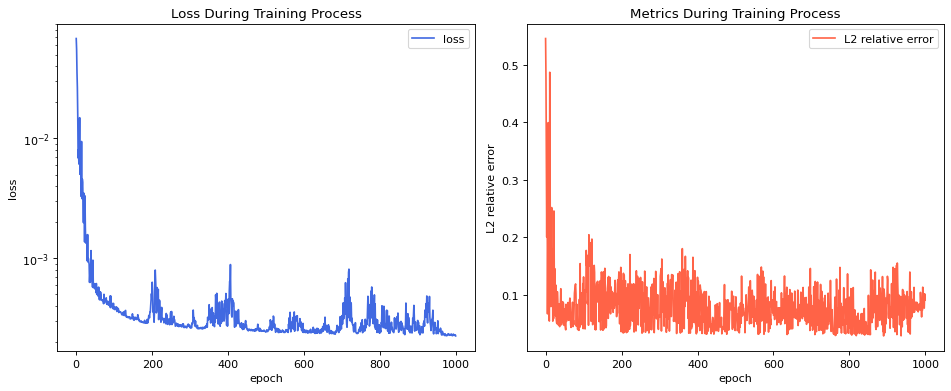

In [ ]:
model_encoder_3.show_train_process()

**(4) 全连接网络[8192->4096->2048->512]，使用BatchNormalization**

In [ ]:
encoder_structure = keras.Sequential([
    Dense(4096),
    BatchNormalization(),
    Activation('relu'),
    Dense(2048),
    BatchNormalization(),
    Activation('relu'),
    Dense(512),
    BatchNormalization(),
    Activation('relu')
])
model_encoder_4 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',
                                      generator=MixedGAN_WD.generator,encoder_layer=encoder_structure)
model_encoder_4.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

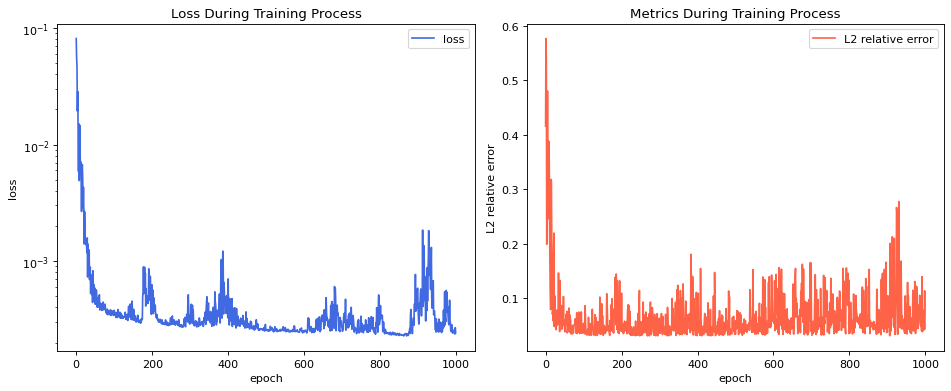

In [ ]:
model_encoder_4.show_train_process()

**(5) 一维CNN**

In [ ]:
encoder_structure = keras.Sequential([
    Reshape(target_shape=(8192,1)),
    keras.layers.Conv1D(8,kernel_size=100,strides=10,activation=None),
    BatchNormalization(),
    Activation('relu'),
    keras.layers.Conv1D(16,kernel_size=100,strides=10,activation=None),
    BatchNormalization(),
    Activation('relu'),
    Flatten()
])
model_encoder_5 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',
                                      generator=MixedGAN_WD.generator,encoder_layer=encoder_structure)
model_encoder_5.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

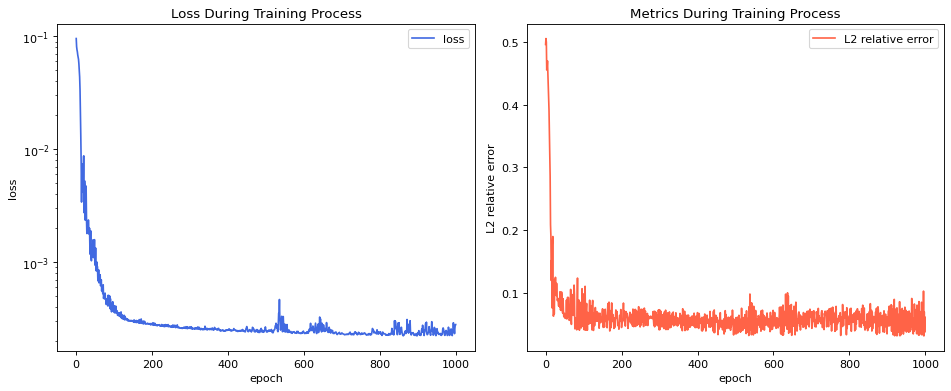

In [ ]:
model_encoder_5.show_train_process()

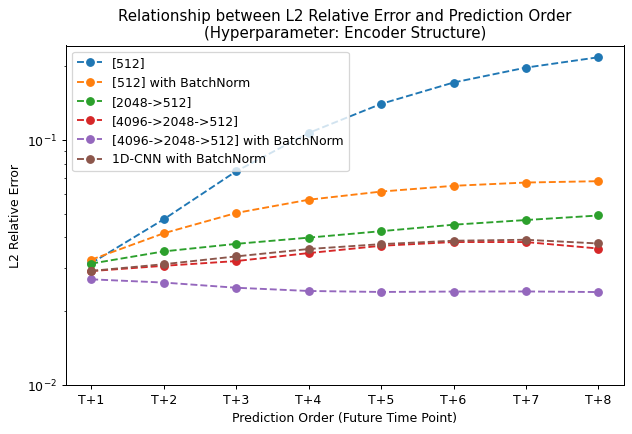

In [ ]:
models = {
    "[512]": model_encoder_1,
    "[512] with BatchNorm": model_encoder_2,
    "[2048->512]": model_lr_2,
    "[4096->2048->512]": model_encoder_3,
    "[4096->2048->512] with BatchNorm": model_encoder_4,
    "1D-CNN with BatchNorm": model_encoder_5
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Encoder Structure',use_log=True)

分析上图中的结果，我们能看到：
* <font color=royalblue>**相较于简单的编码器，一个足够复杂的编码器能有效提取特征、提升模型的性能**</font>
* <font color=royalblue>**足够复杂的编码器能够提升模型预测鲁棒性**</font>  
* <font color=tomato>**BatchNormalization对改进编码器性能，降低L2相对误差有作用**</font>
* <font color=tomato>**一维的卷积网络也能够起到序列降维、提取特征的作用**</font>

### 4.4 LSTM隐藏层的数量

下面，我们来<font color=royalblue>**考虑LSTM的隐藏层数目、分别设置隐藏层数量`num_layers`等于1，2和3**</font>

**(1) num_layers=1**

In [ ]:
model_layers_1 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_layers_1.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False, verbose=False)

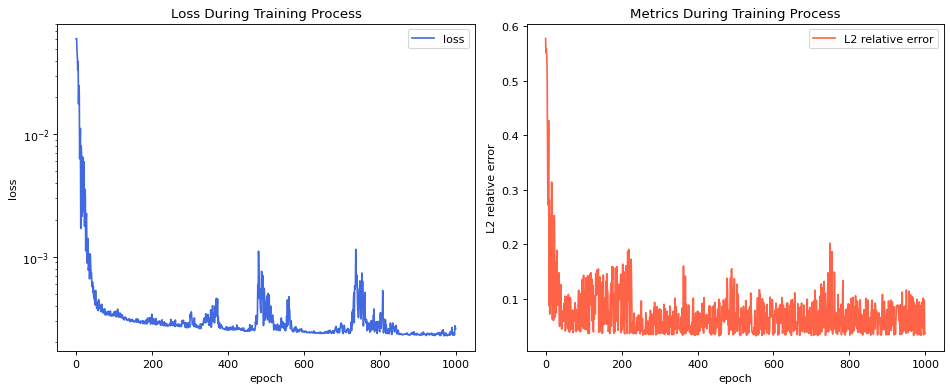

In [ ]:
model_layers_1.show_train_process()

**(2) num_layers=2**

In [ ]:
model_layers_2 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=2,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_layers_2.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False, verbose=False)

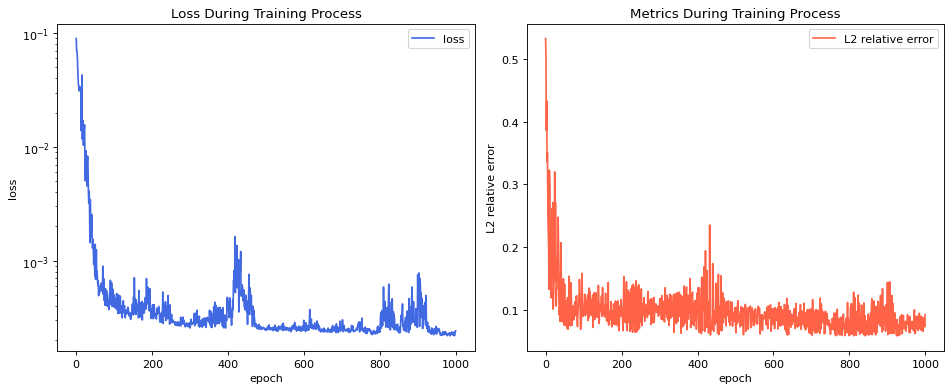

In [ ]:
model_layers_2.show_train_process()

**(3) num_layers=3**

In [ ]:
model_layers_3 = SpatiotemporalModel(num_hiddens=512,num_steps=8,num_layers=3,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_layers_3.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

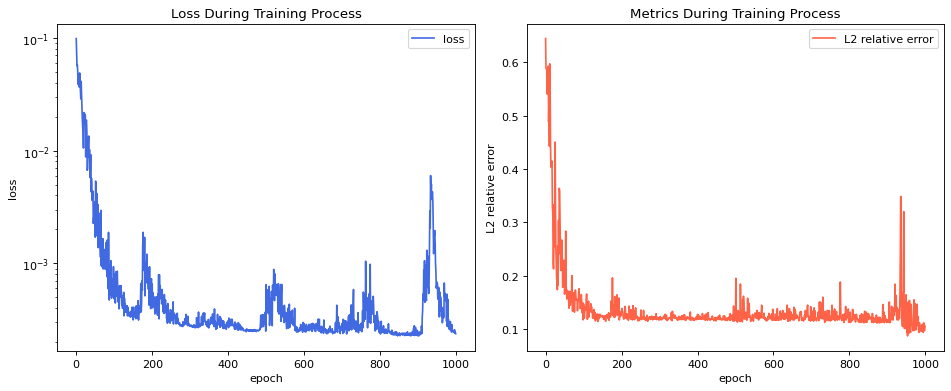

In [ ]:
model_layers_3.show_train_process()

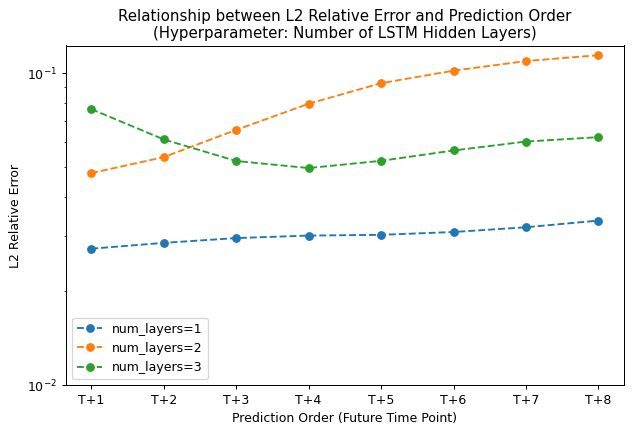

In [ ]:
models = {
    "num_layers=1": model_layers_1,
    "num_layers=2": model_layers_2,
    "num_layers=3": model_layers_3,
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Number of LSTM Hidden Layers',use_log=True)

分析上图中的结果，我们能看到：
* <font color=royalblue>**相较于深层循环神经网络，仅使用一层隐藏层的LSTM能取得更好更稳定的结果**</font>
* <font color=tomato>**隐藏层的更新使损失和L2相对误差的更新变得不稳定，需要引入其它技术来解决**</font>

### 4.5 提供历史信息的长度

我们来<font color=royalblue>**考虑提供给模型的历史压强场信息的序列长度num_steps，分别取num_steps等于4，6，8，10**</font>

**(1) num_steps=4**

In [ ]:
model_steps_1 = SpatiotemporalModel(num_hiddens=512,num_steps=4,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_steps_1.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

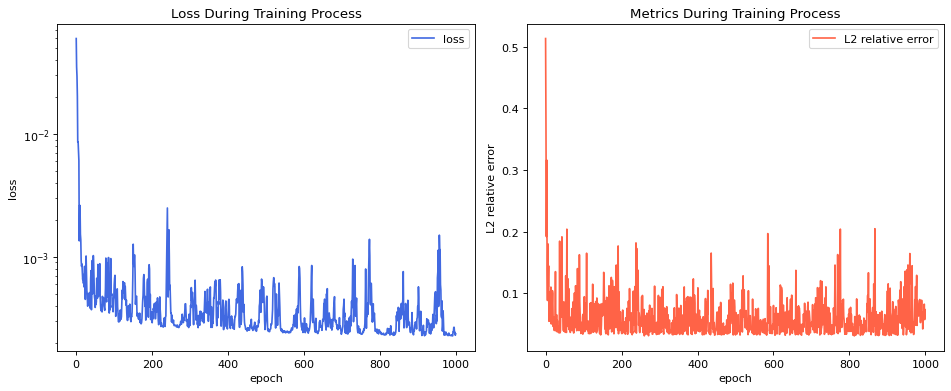

In [ ]:
model_steps_1.show_train_process()

**(2) num_steps=6**

In [ ]:
model_steps_2 = SpatiotemporalModel(num_hiddens=512,num_steps=6,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_steps_2.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

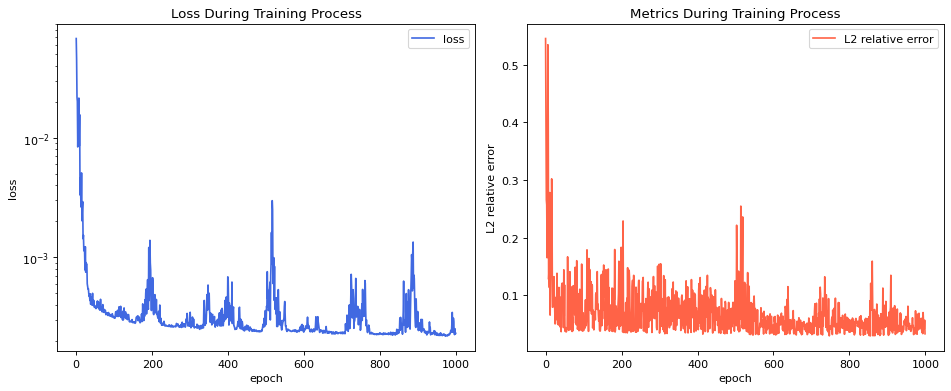

In [ ]:
model_steps_2.show_train_process()

**(3) num_steps=8**

<font color=purple>**(注：4.4节中的模型`model_layers_1`的num_steps=8，因此不必重复进行实验)**</font>

**(4) num_steps=10**

In [ ]:
model_steps_3 = SpatiotemporalModel(num_hiddens=512,num_steps=10,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_steps_3.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=False,verbose=False)

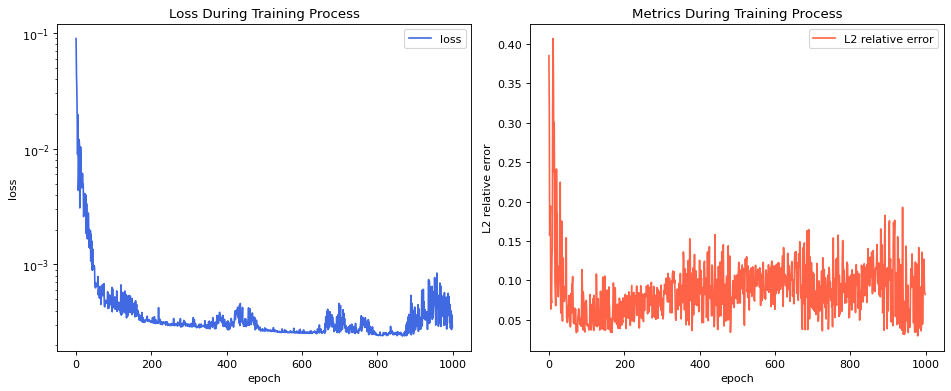

In [ ]:
model_steps_3.show_train_process()

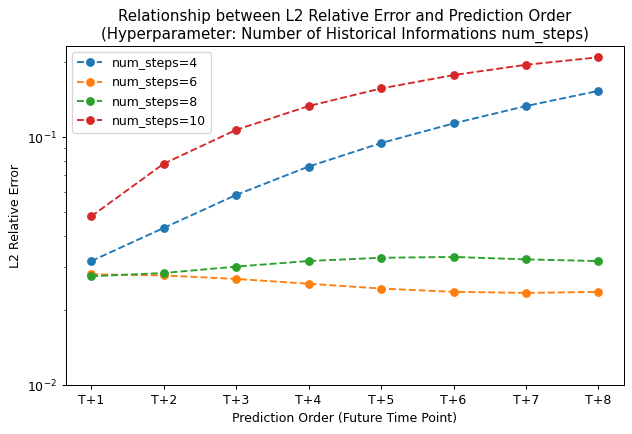

In [ ]:
models = {
    "num_steps=4": model_steps_1,
    "num_steps=6": model_steps_2,
    "num_steps=8": model_layers_1,
    "num_steps=10": model_steps_3,
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Number of Historical Informations num_steps',use_log=True)

分析上图中的结果，我们能看到：
* <font color=royalblue>**过长和过短的历史序列都不利于模型学习和推理，对应模型的损失和L2相对误差在更新时振荡明显**</font>
* <font color=tomato>**针对该问题，较为合适的历史信息序列长度因该设置为6至8**</font>

### 4.6 训练序列的生成方式

最后，我们<font color=tomato>**考虑采用两种方式来生成训练序列，一种是之前所有实验中使用的序列顺序生成，另一种是批量间序列不连续的随机生成**</font>

**(1) 顺序生成**

<font color=purple>**(注：4.4节中的模型`model_layers_1`即使用的顺序生成，因此不必重复进行实验)**</font>

**(2) 随机生成**

In [ ]:
model_random = SpatiotemporalModel(num_hiddens=512,num_steps=10,num_layers=1,scheme='GAN-LSTM',generator=MixedGAN_WD.generator)
model_random.train(EPOCHS=1000,batch_size=8,learning_rate=0.0001, use_random_iter=True,verbose=False)

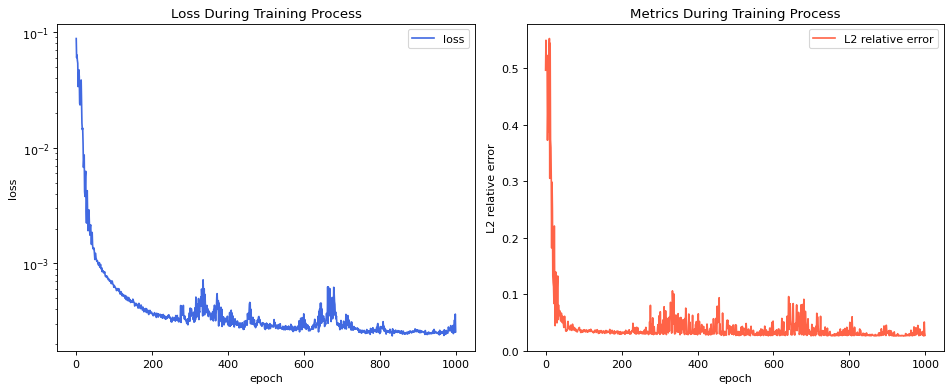

In [ ]:
model_random.show_train_process()

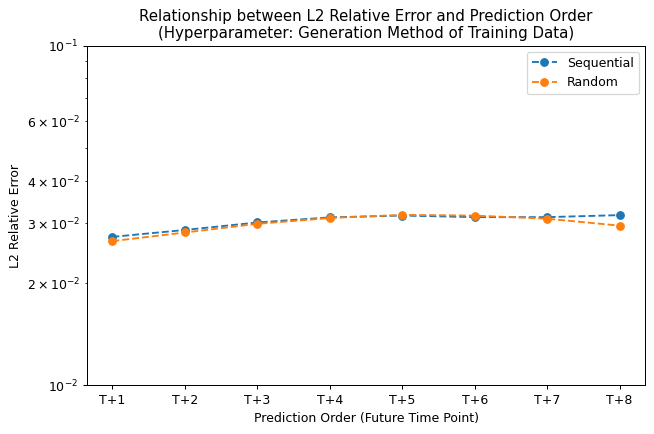

In [ ]:
models = {
    "Sequential": model_layers_1,
    "Random": model_random
}
L2_relative_error_over_time(models,preinfo_steps=8,pred_steps=8,hyperparameter='Generation Method of Training Data',use_log=True)

通过多次实验，我们得到<font color=royalblue>**每个批量的序列是否在时间维度上连续对模型的性能影响不大，在训练时使用每批次随机采样和顺序生成都可以**</font>

### 4.7 调优效果检验

现在，我们<font color=royalblue>**选取调优得到的最优模型，观察模型预测与Ground Truth的对比结果**</font>

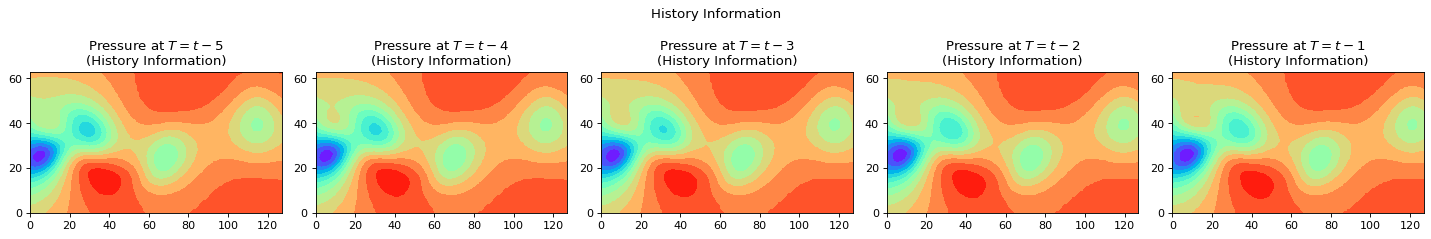

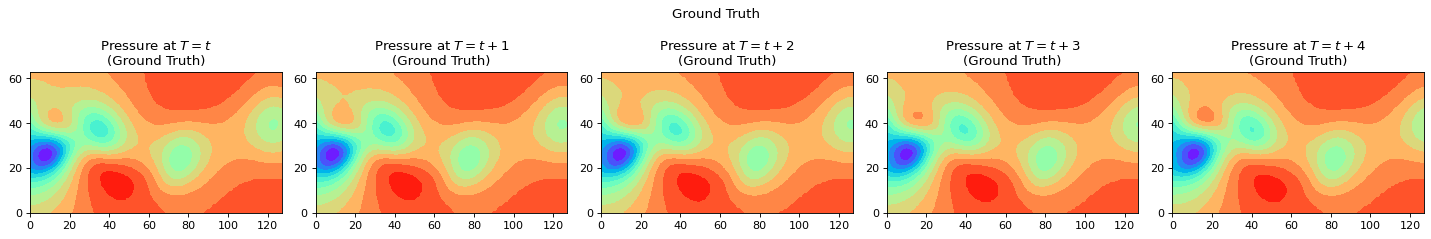

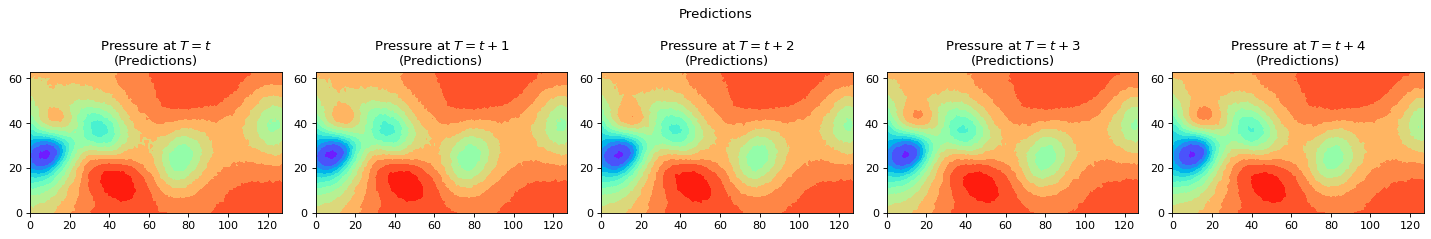

In [ ]:
model_layers_1.show_ground_truth()

现在，<font color=tomato>**模型能更正确地预测未来压强场的分布情况，包括低压中心的移动和演化，高压中心的生成**</font>

----

## 5 结论和总结

### 5.1 实验结论

我们<font color=royalblue>**首先利用压强场在不同时刻的分布信息训练了一个对抗生成神经网络(GAN)**</font>，然后<font color=royalblue>**将GAN模型中的生成器$G$剥离并冻结训练，与一个LSTM网络连接得到GAN-LSTM模型**</font>，GAN-LSTM模型可以用于<font color=royalblue>**解决时空序列预测问题**</font>，借助GAN模型的生成能力和LSTM模型的时序学习能力，<font color=royalblue>**GAN-LSTM模型的时空序列预测能力相较一般的AutoencoderLSTM模型提升很大**</font>

我们将所有的实验过程和结果简单总结如下：
* 借助GAN的生成能力对压强场的分布进行建模，经过合理设置，<font color=tomato>**GAN能正确描述压强场的分布**</font>
* <font color=tomato>**不同配置的GAN模型性能表现差异大**</font>，不同损失函数、优化器和网络结构将会直接影响生成效果，而<font color=tomato>**GAN的生成效果很大程度上决定了最终GAN-LSTM模型的预测效果**</font>
* <font color=tomato>**LSTM模型能学习到压强场的时序变化信息**</font>，我们<font color=royalblue>**基于LSTM和编码-解码器**</font>流程设计了AutoencoderLSTM和GAN-LSTM两个预测模型进行对比
* 在相同参数配置下，<font color=tomato>**AutoencoderLSTM模型的预测得到的压强场携带大量噪声**</font>，无法正确表达压强场的分布，而借助GAN的生成能力，GAN-LSTM表现良好，压强场预测结果准确
* 我们基于<font color=royalblue>**L2相对误差评估GAN-LSTM模型预测的准确性**</font>，实验结果表明，<font color=tomato>**GAN-LSTM网络的训练需要使用小学习率进行，优化器建议使用Adam**</font>
* 使用一个<font color=tomato>**足够复杂且精心设计过的编码器能有效提高预测性能**</font>
* 我们还研究了<font color=royalblue>**LSTM隐藏层数量、历史信息的步长、训练序列的生成方式**</font>等对模型性能的影响

### 5.2 应用前景

目前，人们处理物理信息场的求解和预测大都使用数值微分方程建模的方法。无论是流体流动、大气运动还是温度传递等场景、压强、涡度、温度等物理量的更新变化一般会满足流体力学方程(如Navier-Stokes方程)或椭圆形方程(如对流扩散方程)，这些方程至今无法求得解析解，数值方法在求解大规模动力系统时也面临巨大的挑战。GAN-LSTM从另一个角度求解物理场的求解和预测问题，我们将物理信息转换为纯粹的图像并借助GAN的生成能力学习数据的分布，然后利用LSTM的时序学习能力对未来场的更新进行预测。这避免了复杂困难的数学推导，并且在算力充足的条件下、大规模动力系统的求解(例如大气流动和天气预测)也可以考虑使用GAN-LSTM模型

### 5.3 未来研究方向

在实验过程中，有以下问题有待提升和解决：
* 实验中发现、<font color=royalblue>**无论如何调优网络，L2相对误差最多降低至0.02左右**</font>，结合模型的结构特点考虑，这可能是<font color=tomato>**由于GAN的生成效果限制了精度的进一步提高**</font>，我们需要提高GAN模型的表现能力
* 现在<font color=royalblue>**我们处理的问题压强场在规律变化，但现实中物理场受到外界扰动后，场的更新会使其失去原有的分布特征**</font>，则GAN的生成会失效，我们<font color=tomato>**应该加强GAN生成性能的多元性**</font>
* <font color=tomato>**更细致地研究GAN-LSTM网络中编码器和解码器结构的设计**</font>，也能帮助模型提高预测性能

----

## 6 参考文献

[[1] M. Raissi, P. Perdikaris, G. E. Karniadakis, Physics-informed neural networks: a deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378 (2019) 686–707.](https://www.sciencedirect.com/science/article/pii/S0021999118307125)  
[[2] Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza et al., Generative Adversarial Networks, arXiv preprint, arXiv:1406.2661, 2014.](https://arxiv.org/abs/1406.2661)  
[[3] Martin Arjovsky, Soumith Chintala, Léon Bottou, Wasserstein GAN, arXiv preprint, arXiv:1701.07875, 2017.](https://arxiv.org/abs/1701.07875)  
[[4] Alec Radford, Luke Metz, Soumith Chintala, Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, arXiv preprint, 	arXiv:1511.06434, 2015.](https://arxiv.org/abs/1511.06434)  
[[5] Z. Xu, J. Du, J. Wang, C. Jiang and Y. Ren, "Satellite Image Prediction Relying on GAN and LSTM Neural Networks," ICC 2019 - 2019 IEEE International Conference on Communications (ICC), 2019, pp. 1-6, doi: 10.1109/ICC.2019.8761462.](https://ieeexplore.ieee.org/abstract/document/8761462/similar#similar)

----